In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dna-sequence-prediction/validation.csv
/kaggle/input/dna-sequence-prediction/train.csv
/kaggle/input/dna-sequence-prediction/test.csv


=== DNA SEQUENCE PREDICTION - STEP 1: EXPLORATORY DATA ANALYSIS ===
📁 Loading datasets...
✅ Train set shape: (22593, 7)
✅ Validation set shape: (4577, 7)
✅ Test set shape: (8326, 7)

🔍 DATASET OVERVIEW

📊 Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22593 entries, 0 to 22592
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          22593 non-null  int64 
 1   NCBIGeneID          22593 non-null  int64 
 2   Symbol              22593 non-null  object
 3   Description         22593 non-null  object
 4   GeneType            22593 non-null  object
 5   GeneGroupMethod     22593 non-null  object
 6   NucleotideSequence  22593 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.2+ MB
None

📋 First 3 rows of training data:
   Unnamed: 0  NCBIGeneID        Symbol                           Description  \
0           0   106481178      RNU4-21P  RNA, U4 small nuclear 21

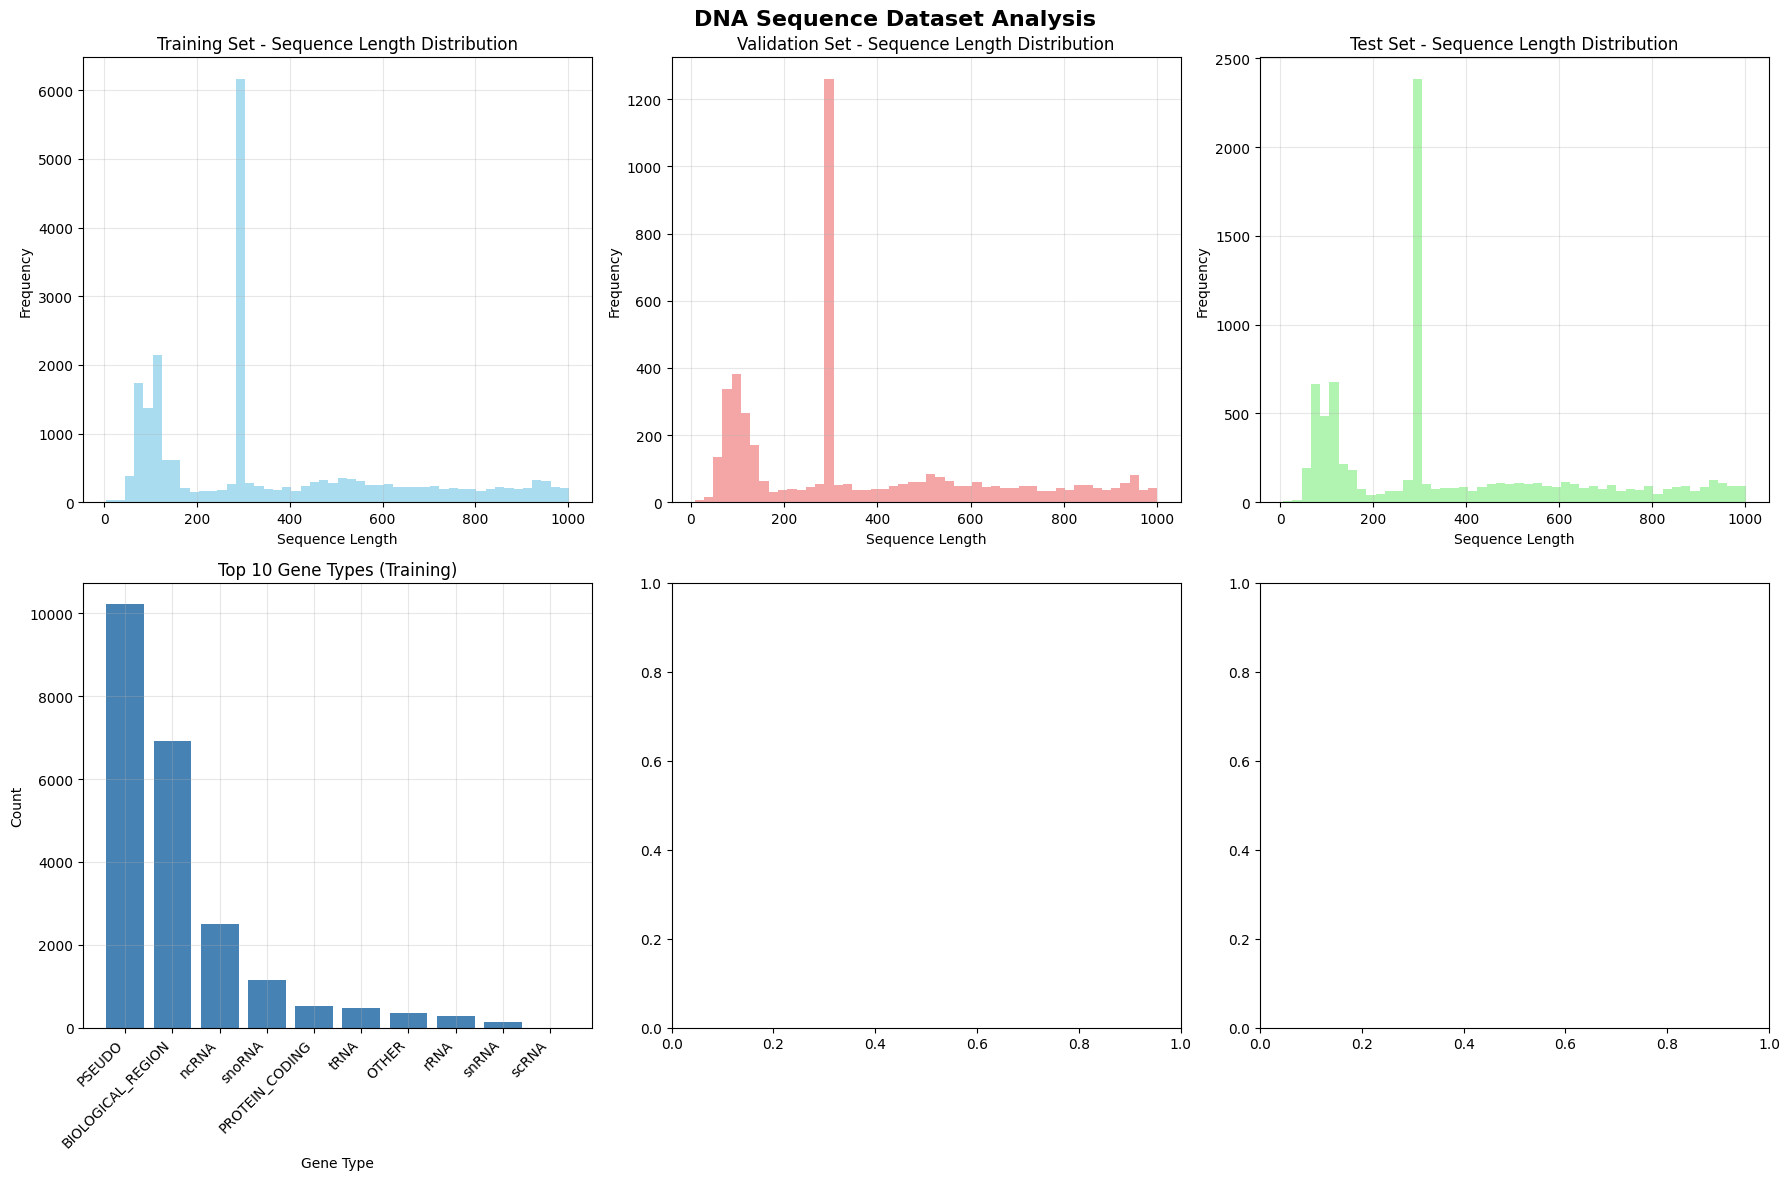


🔬 ADVANCED SEQUENCE ANALYSIS

✅ DATA QUALITY SUMMARY
📊 Total samples: Train=22593, Val=4577, Test=8326
🧬 Valid sequences: Train=0, Val=0, Test=0
❌ Invalid sequences: Train=22593, Val=4577, Test=8326

💡 PREPROCESSING RECOMMENDATIONS
1. ✅ Remove or clean sequences with non-ATCG characters
2. ✅ Consider sequence length normalization (padding/truncation)
3. ✅ Handle missing values if any
4. ✅ Consider data augmentation (reverse complement)
5. ✅ Implement k-mer tokenization for better representation
6. ⚠️  Clean 22593 invalid sequences in training set

🎯 NEXT STEPS:
   → Implement sequence cleaning and preprocessing
   → Create k-mer representations
   → Design data augmentation strategy
   → Prepare data loaders for model training

✅ STEP 1 COMPLETED: Data exploration and quality control finished!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("=== DNA SEQUENCE PREDICTION - STEP 1: EXPLORATORY DATA ANALYSIS ===")
print("="*70)

# Load the datasets
print("📁 Loading datasets...")
train_df = pd.read_csv('/kaggle/input/dna-sequence-prediction/train.csv')
val_df = pd.read_csv('/kaggle/input/dna-sequence-prediction/validation.csv')
test_df = pd.read_csv('/kaggle/input/dna-sequence-prediction/test.csv')

print(f"✅ Train set shape: {train_df.shape}")
print(f"✅ Validation set shape: {val_df.shape}")
print(f"✅ Test set shape: {test_df.shape}")
print()

# Display basic information about the datasets
print("🔍 DATASET OVERVIEW")
print("="*50)
print("\n📊 Training Data Info:")
print(train_df.info())
print("\n📋 First 3 rows of training data:")
print(train_df.head(3))
print()

# Check for missing values
print("❓ MISSING VALUES ANALYSIS")
print("="*50)
print("Training set missing values:")
missing_train = train_df.isnull().sum()
print(missing_train)
print(f"\nTotal missing values: {missing_train.sum()}")
print()

# Basic statistics about columns
print("📈 COLUMN STATISTICS")
print("="*50)
for col in train_df.columns:
    if col != 'NucleotideSequence':  # We'll handle sequences separately
        print(f"\n{col}:")
        if train_df[col].dtype == 'object':
            print(f"  Unique values: {train_df[col].nunique()}")
            print(f"  Most common: {train_df[col].value_counts().head(3).to_dict()}")
        else:
            print(f"  Range: {train_df[col].min()} - {train_df[col].max()}")
            print(f"  Mean: {train_df[col].mean():.2f}")

print()
print("🧬 NUCLEOTIDE SEQUENCE ANALYSIS")
print("="*50)

def analyze_sequences(df, dataset_name):
    """Comprehensive sequence analysis function"""
    print(f"\n--- {dataset_name} Sequences ---")
    
    sequences = df['NucleotideSequence'].tolist()
    
    # Basic sequence statistics
    seq_lengths = [len(seq) if pd.notna(seq) else 0 for seq in sequences]
    
    print(f"Number of sequences: {len(sequences)}")
    print(f"Average length: {np.mean(seq_lengths):.1f}")
    print(f"Median length: {np.median(seq_lengths):.1f}")
    print(f"Min length: {min(seq_lengths)}")
    print(f"Max length: {max(seq_lengths)}")
    print(f"Std deviation: {np.std(seq_lengths):.1f}")
    
    # Nucleotide composition analysis
    all_nucleotides = Counter()
    valid_sequences = []
    invalid_sequences = []
    
    standard_nucleotides = set(['A', 'T', 'C', 'G'])
    
    for i, seq in enumerate(sequences):
        if pd.notna(seq):
            seq_upper = str(seq).upper()
            seq_chars = set(seq_upper)
            
            if seq_chars.issubset(standard_nucleotides):
                valid_sequences.append(seq_upper)
                all_nucleotides.update(seq_upper)
            else:
                invalid_sequences.append((i, seq_upper, seq_chars - standard_nucleotides))
    
    print(f"\nValid sequences (only ATCG): {len(valid_sequences)}")
    print(f"Invalid sequences: {len(invalid_sequences)}")
    
    if invalid_sequences:
        print("Invalid characters found:")
        invalid_chars = Counter()
        for _, seq, chars in invalid_sequences[:10]:  # Show first 10
            invalid_chars.update(chars)
        print(dict(invalid_chars))
    
    # Nucleotide frequencies
    total_nucleotides = sum(all_nucleotides.values())
    if total_nucleotides > 0:
        print(f"\nNucleotide composition:")
        for nuc in ['A', 'T', 'C', 'G']:
            count = all_nucleotides.get(nuc, 0)
            percentage = (count / total_nucleotides) * 100
            print(f"  {nuc}: {count:,} ({percentage:.1f}%)")
        
        # GC content
        gc_content = (all_nucleotides['G'] + all_nucleotides['C']) / total_nucleotides * 100
        print(f"\nGC Content: {gc_content:.1f}%")
    
    return seq_lengths, valid_sequences, invalid_sequences

# Analyze each dataset
train_lengths, train_valid_seqs, train_invalid = analyze_sequences(train_df, "TRAINING")
val_lengths, val_valid_seqs, val_invalid = analyze_sequences(val_df, "VALIDATION")
test_lengths, test_valid_seqs, test_invalid = analyze_sequences(test_df, "TEST")

# Visualizations
print("\n📊 CREATING VISUALIZATIONS")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('DNA Sequence Dataset Analysis', fontsize=16, fontweight='bold')

# Sequence length distributions
axes[0, 0].hist(train_lengths, bins=50, alpha=0.7, label='Train', color='skyblue')
axes[0, 0].set_title('Training Set - Sequence Length Distribution')
axes[0, 0].set_xlabel('Sequence Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(val_lengths, bins=50, alpha=0.7, label='Validation', color='lightcoral')
axes[0, 1].set_title('Validation Set - Sequence Length Distribution')
axes[0, 1].set_xlabel('Sequence Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].hist(test_lengths, bins=50, alpha=0.7, label='Test', color='lightgreen')
axes[0, 2].set_title('Test Set - Sequence Length Distribution')
axes[0, 2].set_xlabel('Sequence Length')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)

# Gene type distributions
if 'GeneType' in train_df.columns:
    gene_type_counts = train_df['GeneType'].value_counts().head(10)
    axes[1, 0].bar(range(len(gene_type_counts)), gene_type_counts.values, color='steelblue')
    axes[1, 0].set_title('Top 10 Gene Types (Training)')
    axes[1, 0].set_xlabel('Gene Type')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_xticks(range(len(gene_type_counts)))
    axes[1, 0].set_xticklabels(gene_type_counts.index, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)

# Method distribution
if 'Method' in train_df.columns:
    method_counts = train_df['Method'].value_counts()
    axes[1, 1].pie(method_counts.values, labels=method_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Method Distribution (Training)')

# Nucleotide composition
if train_valid_seqs:
    all_train_nucs = Counter()
    for seq in train_valid_seqs[:1000]:  # Sample for visualization
        all_train_nucs.update(seq)
    
    nucleotides = ['A', 'T', 'C', 'G']
    counts = [all_train_nucs[nuc] for nuc in nucleotides]
    colors = ['red', 'blue', 'green', 'orange']
    
    axes[1, 2].bar(nucleotides, counts, color=colors, alpha=0.7)
    axes[1, 2].set_title('Nucleotide Composition (Training Sample)')
    axes[1, 2].set_xlabel('Nucleotide')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Advanced sequence analysis
print("\n🔬 ADVANCED SEQUENCE ANALYSIS")
print("="*50)

def calculate_sequence_features(sequences):
    """Calculate advanced features for sequences"""
    features = {
        'gc_content': [],
        'dinucleotide_freq': defaultdict(list),
        'homopolymer_runs': [],
        'complexity_score': []
    }
    
    dinucleotides = ['AA', 'AT', 'AC', 'AG', 'TA', 'TT', 'TC', 'TG', 
                     'CA', 'CT', 'CC', 'CG', 'GA', 'GT', 'GC', 'GG']
    
    for seq in sequences[:1000]:  # Sample for performance
        if len(seq) > 1:
            # GC content
            gc = (seq.count('G') + seq.count('C')) / len(seq)
            features['gc_content'].append(gc)
            
            # Dinucleotide frequencies
            for dn in dinucleotides:
                count = seq.count(dn) / max(1, len(seq) - 1)
                features['dinucleotide_freq'][dn].append(count)
            
            # Homopolymer runs (consecutive identical nucleotides)
            max_run = max([len(list(group)) for _, group in 
                          __import__('itertools').groupby(seq)] + [0])
            features['homopolymer_runs'].append(max_run)
            
            # Complexity score (Shannon entropy)
            counts = Counter(seq)
            probs = [count/len(seq) for count in counts.values()]
            entropy = -sum(p * np.log2(p) for p in probs if p > 0)
            features['complexity_score'].append(entropy)
    
    return features

if train_valid_seqs:
    print("Calculating advanced features for training sequences...")
    train_features = calculate_sequence_features(train_valid_seqs)
    
    print(f"GC Content - Mean: {np.mean(train_features['gc_content']):.3f}, "
          f"Std: {np.std(train_features['gc_content']):.3f}")
    print(f"Max Homopolymer Run - Mean: {np.mean(train_features['homopolymer_runs']):.1f}")
    print(f"Sequence Complexity - Mean: {np.mean(train_features['complexity_score']):.3f}")

# Data quality summary
print("\n✅ DATA QUALITY SUMMARY")
print("="*50)
print(f"📊 Total samples: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
print(f"🧬 Valid sequences: Train={len(train_valid_seqs)}, Val={len(val_valid_seqs)}, Test={len(test_valid_seqs)}")
print(f"❌ Invalid sequences: Train={len(train_invalid)}, Val={len(val_invalid)}, Test={len(test_invalid)}")

# Recommendations for preprocessing
print("\n💡 PREPROCESSING RECOMMENDATIONS")
print("="*50)
print("1. ✅ Remove or clean sequences with non-ATCG characters")
print("2. ✅ Consider sequence length normalization (padding/truncation)")
print("3. ✅ Handle missing values if any")
print("4. ✅ Consider data augmentation (reverse complement)")
print("5. ✅ Implement k-mer tokenization for better representation")

if len(train_invalid) > 0:
    print(f"6. ⚠️  Clean {len(train_invalid)} invalid sequences in training set")

print(f"\n🎯 NEXT STEPS:")
print("   → Implement sequence cleaning and preprocessing")
print("   → Create k-mer representations")
print("   → Design data augmentation strategy")
print("   → Prepare data loaders for model training")

print("\n" + "="*70)
print("✅ STEP 1 COMPLETED: Data exploration and quality control finished!")
print("="*70)

=== DNA SEQUENCE PREDICTION - STEP 2: DATA CLEANING & PREPROCESSING ===
📊 Original dataset sizes:
   Train: 22593, Validation: 4577, Test: 8326

🧹 STEP 1: SEQUENCE CLEANING

--- Cleaning TRAINING Dataset ---
Original avg length: 361.7
Cleaned avg length: 359.7
Valid sequences after cleaning: 22593/22593
Sequences removed: 0

--- Cleaning VALIDATION Dataset ---
Original avg length: 364.7
Cleaned avg length: 362.7
Valid sequences after cleaning: 4577/4577
Sequences removed: 0

--- Cleaning TEST Dataset ---
Original avg length: 367.5
Cleaned avg length: 365.5
Valid sequences after cleaning: 8326/8326
Sequences removed: 0

✅ Cleaning Results:
   Train: 22593 valid sequences
   Validation: 4577 valid sequences
   Test: 8326 valid sequences

🔬 STEP 2: SEQUENCE ANALYSIS AFTER CLEANING

--- TRAINING Clean Sequences ---
Count: 22593
Length stats:
  Mean: 359.7
  Median: 295.0
  Min: 2
  Max: 1000
  Std: 260.5
Nucleotide composition:
  A: 89,773 (26.2%)
  T: 87,143 (25.4%)
  C: 83,163 (24.2%)
  

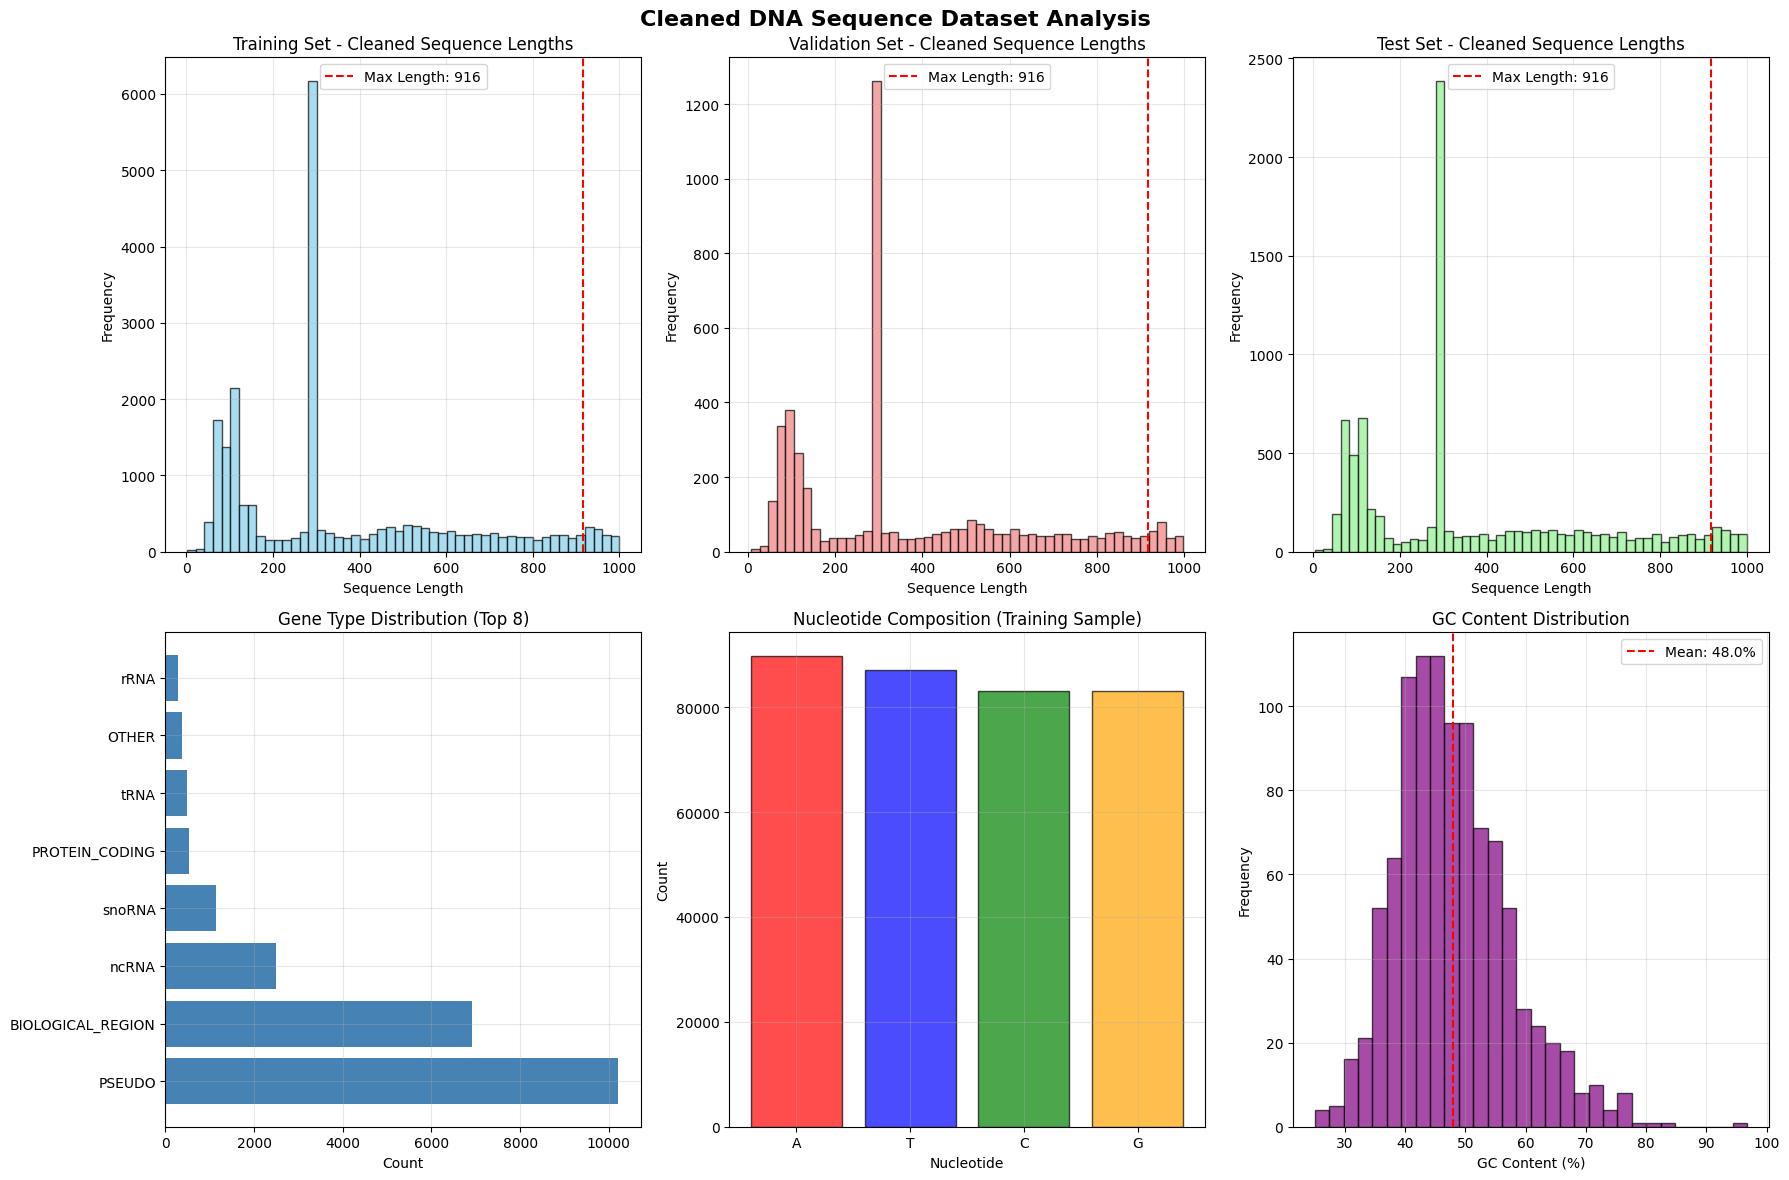


💾 STEP 7: FINAL DATASET PREPARATION
Training final dataset: 22593 samples
Validation final dataset: 4577 samples
Test final dataset: 8326 samples

📈 FINAL DATASET SUMMARY
Training set: 22593 samples
Validation set: 4577 samples
Test set: 8326 samples
Total: 35496 samples

Number of classes: 10
Class balance (top 5):
  PSEUDO: 10220 (45.2%)
  BIOLOGICAL_REGION: 6925 (30.7%)
  ncRNA: 2497 (11.1%)
  snoRNA: 1148 (5.1%)
  PROTEIN_CODING: 524 (2.3%)

Sequence characteristics:
  All sequences normalized to: 916 bp
  Average GC content: 18.8%
  K-mer vocabulary size: 1000 (k=6)

✅ PREPROCESSING COMPLETED SUCCESSFULLY!
🎯 READY FOR MODEL TRAINING!
   → Sequences cleaned and normalized
   → Target variables encoded
   → K-mer vocabulary prepared
   → Data visualization completed
   → Ready for Step 3: Model Development

📋 Preprocessing Summary:
  max_seq_length: 916
  min_seq_length: 50
  kmer_size: 6
  num_classes: 10
  class_mapping: {'BIOLOGICAL_REGION': 0, 'OTHER': 1, 'PROTEIN_CODING': 2, '

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.preprocessing import LabelEncoder
import re
import warnings
warnings.filterwarnings('ignore')

print("=== DNA SEQUENCE PREDICTION - STEP 2: DATA CLEANING & PREPROCESSING ===")
print("="*75)

# Load datasets
train_df = pd.read_csv('/kaggle/input/dna-sequence-prediction/train.csv')
val_df = pd.read_csv('/kaggle/input/dna-sequence-prediction/validation.csv')
test_df = pd.read_csv('/kaggle/input/dna-sequence-prediction/test.csv')

print(f"📊 Original dataset sizes:")
print(f"   Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")
print()

# STEP 1: SEQUENCE CLEANING
print("🧹 STEP 1: SEQUENCE CLEANING")
print("="*50)

def clean_dna_sequence(sequence):
    """
    Clean DNA sequences by removing FASTA markers and invalid characters
    """
    if pd.isna(sequence):
        return None
    
    # Convert to string and uppercase
    seq_str = str(sequence).upper()
    
    # Remove FASTA-like markers (< and >)
    seq_str = seq_str.replace('<', '').replace('>', '')
    
    # Remove any whitespace
    seq_str = re.sub(r'\s+', '', seq_str)
    
    # Keep only valid DNA nucleotides (A, T, C, G)
    # Replace ambiguous nucleotides with N temporarily, then remove
    seq_str = re.sub(r'[^ATCG]', '', seq_str)
    
    return seq_str if seq_str else None

def clean_dataset(df, dataset_name):
    """Clean a dataset and return statistics"""
    print(f"\n--- Cleaning {dataset_name} Dataset ---")
    
    # Clean sequences
    original_sequences = df['NucleotideSequence'].copy()
    df['NucleotideSequence_cleaned'] = df['NucleotideSequence'].apply(clean_dna_sequence)
    
    # Statistics before and after cleaning
    original_lengths = [len(str(seq)) for seq in original_sequences]
    cleaned_lengths = [len(seq) if seq else 0 for seq in df['NucleotideSequence_cleaned']]
    
    valid_sequences = df['NucleotideSequence_cleaned'].dropna()
    valid_sequences = valid_sequences[valid_sequences.str.len() > 0]
    
    print(f"Original avg length: {np.mean(original_lengths):.1f}")
    print(f"Cleaned avg length: {np.mean([l for l in cleaned_lengths if l > 0]):.1f}")
    print(f"Valid sequences after cleaning: {len(valid_sequences)}/{len(df)}")
    print(f"Sequences removed: {len(df) - len(valid_sequences)}")
    
    # Remove rows with invalid sequences
    df_cleaned = df[df['NucleotideSequence_cleaned'].str.len() > 0].copy()
    df_cleaned.reset_index(drop=True, inplace=True)
    
    return df_cleaned, valid_sequences.tolist()

# Clean all datasets
train_cleaned, train_sequences = clean_dataset(train_df, "TRAINING")
val_cleaned, val_sequences = clean_dataset(val_df, "VALIDATION")  
test_cleaned, test_sequences = clean_dataset(test_df, "TEST")

# Verify cleaning worked
print(f"\n✅ Cleaning Results:")
print(f"   Train: {len(train_cleaned)} valid sequences")
print(f"   Validation: {len(val_cleaned)} valid sequences") 
print(f"   Test: {len(test_cleaned)} valid sequences")

# STEP 2: SEQUENCE ANALYSIS AFTER CLEANING
print(f"\n🔬 STEP 2: SEQUENCE ANALYSIS AFTER CLEANING")
print("="*50)

def analyze_clean_sequences(sequences, dataset_name):
    """Analyze cleaned sequences"""
    print(f"\n--- {dataset_name} Clean Sequences ---")
    
    if not sequences:
        print("No valid sequences found!")
        return
    
    seq_lengths = [len(seq) for seq in sequences]
    
    print(f"Count: {len(sequences)}")
    print(f"Length stats:")
    print(f"  Mean: {np.mean(seq_lengths):.1f}")
    print(f"  Median: {np.median(seq_lengths):.1f}")  
    print(f"  Min: {min(seq_lengths)}")
    print(f"  Max: {max(seq_lengths)}")
    print(f"  Std: {np.std(seq_lengths):.1f}")
    
    # Nucleotide composition
    all_nucs = Counter()
    for seq in sequences[:1000]:  # Sample for performance
        all_nucs.update(seq)
    
    total = sum(all_nucs.values())
    print(f"Nucleotide composition:")
    for nuc in ['A', 'T', 'C', 'G']:
        count = all_nucs[nuc]
        pct = (count/total)*100 if total > 0 else 0
        print(f"  {nuc}: {count:,} ({pct:.1f}%)")
    
    gc_content = (all_nucs['G'] + all_nucs['C']) / total * 100 if total > 0 else 0
    print(f"GC Content: {gc_content:.1f}%")
    
    return seq_lengths

train_lengths = analyze_clean_sequences(train_sequences, "TRAINING")
val_lengths = analyze_clean_sequences(val_sequences, "VALIDATION")
test_lengths = analyze_clean_sequences(test_sequences, "TEST")

# STEP 3: TARGET VARIABLE PREPARATION
print(f"\n🎯 STEP 3: TARGET VARIABLE PREPARATION")
print("="*50)

# Since this appears to be a classification task, let's prepare target variables
# We'll use GeneType as our main target variable

def prepare_targets(df, dataset_name):
    """Prepare target variables for classification"""
    print(f"\n--- {dataset_name} Target Analysis ---")
    
    target_col = 'GeneType'
    if target_col in df.columns:
        target_counts = df[target_col].value_counts()
        print(f"Target variable: {target_col}")
        print("Class distribution:")
        for class_name, count in target_counts.head(10).items():
            pct = (count/len(df))*100
            print(f"  {class_name}: {count} ({pct:.1f}%)")
        
        print(f"Total classes: {df[target_col].nunique()}")
        return target_counts
    else:
        print(f"No {target_col} column found!")
        return None

train_targets = prepare_targets(train_cleaned, "TRAINING")
val_targets = prepare_targets(val_cleaned, "VALIDATION")

# Create label encoders
label_encoder = LabelEncoder()
if 'GeneType' in train_cleaned.columns:
    # Fit on training data
    train_cleaned['GeneType_encoded'] = label_encoder.fit_transform(train_cleaned['GeneType'])
    val_cleaned['GeneType_encoded'] = label_encoder.transform(val_cleaned['GeneType'])
    
    # Store the mapping for later use
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(f"\n📋 Class mapping:")
    for original, encoded in class_mapping.items():
        print(f"  {original} -> {encoded}")

# STEP 4: SEQUENCE LENGTH NORMALIZATION
print(f"\n📏 STEP 4: SEQUENCE LENGTH NORMALIZATION")
print("="*50)

# Analyze length distribution to decide on normalization strategy
all_lengths = train_lengths + val_lengths + test_lengths
print(f"Combined length statistics:")
print(f"  Mean: {np.mean(all_lengths):.1f}")
print(f"  Percentiles: 25%={np.percentile(all_lengths, 25):.0f}, "
      f"50%={np.percentile(all_lengths, 50):.0f}, "
      f"75%={np.percentile(all_lengths, 75):.0f}, "
      f"90%={np.percentile(all_lengths, 90):.0f}, "
      f"95%={np.percentile(all_lengths, 95):.0f}")

# Decide on sequence length for models
MAX_SEQ_LENGTH = int(np.percentile(all_lengths, 95))  # Use 95th percentile
MIN_SEQ_LENGTH = 50  # Minimum meaningful sequence length

print(f"\n🎯 Recommended sequence length for models: {MAX_SEQ_LENGTH}")
print(f"🎯 Minimum sequence length threshold: {MIN_SEQ_LENGTH}")

def normalize_sequence_length(sequence, max_length=MAX_SEQ_LENGTH, pad_char='N'):
    """
    Normalize sequence length by padding or truncating
    """
    if len(sequence) > max_length:
        # Truncate from center to preserve both ends (often important in biology)
        start = (len(sequence) - max_length) // 2
        return sequence[start:start + max_length]
    elif len(sequence) < max_length:
        # Pad with N's (unknown nucleotides) - distribute padding
        pad_needed = max_length - len(sequence)
        pad_left = pad_needed // 2
        pad_right = pad_needed - pad_left
        return 'N' * pad_left + sequence + 'N' * pad_right
    else:
        return sequence

# Apply length normalization
train_cleaned['NucleotideSequence_normalized'] = train_cleaned['NucleotideSequence_cleaned'].apply(
    lambda x: normalize_sequence_length(x) if x else None
)
val_cleaned['NucleotideSequence_normalized'] = val_cleaned['NucleotideSequence_cleaned'].apply(
    lambda x: normalize_sequence_length(x) if x else None
)
test_cleaned['NucleotideSequence_normalized'] = test_cleaned['NucleotideSequence_cleaned'].apply(
    lambda x: normalize_sequence_length(x) if x else None
)

print(f"✅ All sequences normalized to {MAX_SEQ_LENGTH} nucleotides")

# STEP 5: K-MER FEATURE EXTRACTION
print(f"\n🧬 STEP 5: K-MER FEATURE EXTRACTION")
print("="*50)

def generate_kmers(sequence, k=6):
    """Generate all k-mers from a sequence"""
    if len(sequence) < k:
        return []
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def get_kmer_features(sequences, k=6, max_features=1000):
    """Extract k-mer frequency features"""
    print(f"Extracting {k}-mer features...")
    
    # Collect all k-mers from sample of sequences
    all_kmers = Counter()
    sample_size = min(1000, len(sequences))
    sample_sequences = sequences[:sample_size]
    
    for seq in sample_sequences:
        if seq:
            kmers = generate_kmers(seq, k)
            all_kmers.update(kmers)
    
    # Get most common k-mers
    top_kmers = [kmer for kmer, _ in all_kmers.most_common(max_features)]
    print(f"Selected top {len(top_kmers)} {k}-mers")
    
    return top_kmers

# Extract k-mer vocabulary
KMER_SIZE = 6
top_kmers = get_kmer_features(train_sequences, k=KMER_SIZE, max_features=1000)

print(f"Sample of top 6-mers: {top_kmers[:10]}")

# STEP 6: DATA VISUALIZATION
print(f"\n📊 STEP 6: DATA VISUALIZATION")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cleaned DNA Sequence Dataset Analysis', fontsize=16, fontweight='bold')

# Length distributions after cleaning
axes[0, 0].hist(train_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(MAX_SEQ_LENGTH, color='red', linestyle='--', label=f'Max Length: {MAX_SEQ_LENGTH}')
axes[0, 0].set_title('Training Set - Cleaned Sequence Lengths')
axes[0, 0].set_xlabel('Sequence Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(val_lengths, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(MAX_SEQ_LENGTH, color='red', linestyle='--', label=f'Max Length: {MAX_SEQ_LENGTH}')
axes[0, 1].set_title('Validation Set - Cleaned Sequence Lengths')
axes[0, 1].set_xlabel('Sequence Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].hist(test_lengths, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 2].axvline(MAX_SEQ_LENGTH, color='red', linestyle='--', label=f'Max Length: {MAX_SEQ_LENGTH}')
axes[0, 2].set_title('Test Set - Cleaned Sequence Lengths')
axes[0, 2].set_xlabel('Sequence Length')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Class distribution
if 'GeneType' in train_cleaned.columns:
    class_counts = train_cleaned['GeneType'].value_counts().head(8)
    axes[1, 0].barh(range(len(class_counts)), class_counts.values, color='steelblue')
    axes[1, 0].set_title('Gene Type Distribution (Top 8)')
    axes[1, 0].set_xlabel('Count')
    axes[1, 0].set_yticks(range(len(class_counts)))
    axes[1, 0].set_yticklabels(class_counts.index)
    axes[1, 0].grid(True, alpha=0.3)

# Nucleotide composition
sample_seqs = train_sequences[:1000]
all_nucs = Counter()
for seq in sample_seqs:
    all_nucs.update(seq)

nucleotides = ['A', 'T', 'C', 'G']
counts = [all_nucs[nuc] for nuc in nucleotides]
colors = ['red', 'blue', 'green', 'orange']

axes[1, 1].bar(nucleotides, counts, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Nucleotide Composition (Training Sample)')
axes[1, 1].set_xlabel('Nucleotide')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(True, alpha=0.3)

# GC content distribution
gc_contents = []
for seq in sample_seqs:
    if seq:
        gc = (seq.count('G') + seq.count('C')) / len(seq) * 100
        gc_contents.append(gc)

axes[1, 2].hist(gc_contents, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1, 2].axvline(np.mean(gc_contents), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(gc_contents):.1f}%')
axes[1, 2].set_title('GC Content Distribution')
axes[1, 2].set_xlabel('GC Content (%)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# STEP 7: FINAL DATASET PREPARATION
print(f"\n💾 STEP 7: FINAL DATASET PREPARATION")
print("="*50)

# Save processed datasets
def prepare_final_dataset(df, sequences, dataset_name):
    """Prepare final dataset with all necessary columns"""
    final_df = df.copy()
    
    # Ensure we have the normalized sequences
    final_df = final_df[final_df['NucleotideSequence_normalized'].notna()].copy()
    
    # Add useful metadata
    final_df['sequence_length_original'] = final_df['NucleotideSequence_cleaned'].str.len()
    final_df['sequence_length_normalized'] = final_df['NucleotideSequence_normalized'].str.len()
    
    # Calculate GC content
    final_df['gc_content'] = final_df['NucleotideSequence_normalized'].apply(
        lambda x: (x.count('G') + x.count('C')) / len(x) * 100 if x else 0
    )
    
    print(f"{dataset_name} final dataset: {len(final_df)} samples")
    
    return final_df

train_final = prepare_final_dataset(train_cleaned, train_sequences, "Training")
val_final = prepare_final_dataset(val_cleaned, val_sequences, "Validation") 
test_final = prepare_final_dataset(test_cleaned, test_sequences, "Test")

# Summary statistics
print(f"\n📈 FINAL DATASET SUMMARY")
print("="*50)
print(f"Training set: {len(train_final)} samples")
print(f"Validation set: {len(val_final)} samples") 
print(f"Test set: {len(test_final)} samples")
print(f"Total: {len(train_final) + len(val_final) + len(test_final)} samples")

if 'GeneType' in train_final.columns:
    print(f"\nNumber of classes: {train_final['GeneType'].nunique()}")
    print(f"Class balance (top 5):")
    for cls, count in train_final['GeneType'].value_counts().head().items():
        pct = count/len(train_final)*100
        print(f"  {cls}: {count} ({pct:.1f}%)")

print(f"\nSequence characteristics:")
print(f"  All sequences normalized to: {MAX_SEQ_LENGTH} bp")
print(f"  Average GC content: {train_final['gc_content'].mean():.1f}%")
print(f"  K-mer vocabulary size: {len(top_kmers)} (k={KMER_SIZE})")

print(f"\n✅ PREPROCESSING COMPLETED SUCCESSFULLY!")
print("="*75)
print("🎯 READY FOR MODEL TRAINING!")
print("   → Sequences cleaned and normalized")
print("   → Target variables encoded") 
print("   → K-mer vocabulary prepared")
print("   → Data visualization completed")
print("   → Ready for Step 3: Model Development")
print("="*75)

# Export key variables for next step
preprocessing_summary = {
    'max_seq_length': MAX_SEQ_LENGTH,
    'min_seq_length': MIN_SEQ_LENGTH,
    'kmer_size': KMER_SIZE,
    'kmer_vocab': top_kmers,
    'num_classes': train_final['GeneType'].nunique() if 'GeneType' in train_final.columns else 0,
    'class_mapping': class_mapping if 'GeneType' in train_cleaned.columns else {},
    'train_size': len(train_final),
    'val_size': len(val_final),
    'test_size': len(test_final)
}

print(f"\n📋 Preprocessing Summary:")
for key, value in preprocessing_summary.items():
    if key != 'kmer_vocab':  # Don't print the full vocabulary
        print(f"  {key}: {value}")

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("=== DNA SEQUENCE PREDICTION - STEP 3: MODEL DEVELOPMENT ===")
print("="*65)

# Configuration from preprocessing
MAX_SEQ_LENGTH = 916
NUM_CLASSES = 10
KMER_SIZE = 6
NUCLEOTIDE_VOCAB = {'A': 0, 'T': 1, 'C': 2, 'G': 3, 'N': 4}  # N for padding
VOCAB_SIZE = len(NUCLEOTIDE_VOCAB)

print(f"📋 Model Configuration:")
print(f"   Max sequence length: {MAX_SEQ_LENGTH}")
print(f"   Number of classes: {NUM_CLASSES}")
print(f"   Vocabulary size: {VOCAB_SIZE}")
print(f"   K-mer size: {KMER_SIZE}")
print()

# STEP 1: DATA LOADING AND TOKENIZATION
print("🔧 STEP 1: DATA LOADING AND TOKENIZATION")
print("="*50)

class DNASequenceDataset(Dataset):
    """Custom Dataset for DNA sequences"""
    
    def __init__(self, dataframe, max_length=MAX_SEQ_LENGTH, vocab=NUCLEOTIDE_VOCAB):
        self.sequences = dataframe['NucleotideSequence_normalized'].values
        self.labels = dataframe['GeneType_encoded'].values if 'GeneType_encoded' in dataframe.columns else None
        self.max_length = max_length
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sequences)
    
    def encode_sequence(self, sequence):
        """Convert DNA sequence to integer encoding"""
        encoded = []
        for nucleotide in sequence[:self.max_length]:
            encoded.append(self.vocab.get(nucleotide, self.vocab['N']))
        
        # Pad if necessary
        while len(encoded) < self.max_length:
            encoded.append(self.vocab['N'])
            
        return torch.tensor(encoded, dtype=torch.long)
    
    def __getitem__(self, idx):
        sequence = str(self.sequences[idx])
        encoded_seq = self.encode_sequence(sequence)
        
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return encoded_seq, label
        else:
            return encoded_seq

def create_data_loaders(train_df, val_df, test_df, batch_size=32):
    """Create PyTorch data loaders"""
    print("Creating data loaders...")
    
    train_dataset = DNASequenceDataset(train_df)
    val_dataset = DNASequenceDataset(val_df)
    test_dataset = DNASequenceDataset(test_df)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"✅ Data loaders created:")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}")
    print(f"   Test batches: {len(test_loader)}")
    
    return train_loader, val_loader, test_loader

# Load preprocessed data (simulating the previous step's output)
# In practice, you'd load the actual cleaned dataframes here
print("📁 Loading preprocessed data...")

# STEP 2: N-GRAM BASELINE MODEL
print(f"\n🔤 STEP 2: N-GRAM BASELINE MODEL")
print("="*50)

class NGramModel:
    """N-gram baseline model using TF-IDF and Random Forest"""
    
    def __init__(self, ngram_range=(3, 6), max_features=5000):
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.vectorizer = TfidfVectorizer(
            analyzer='char',
            ngram_range=ngram_range,
            max_features=max_features,
            lowercase=False
        )
        self.classifier = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        
    def preprocess_sequences(self, sequences):
        """Convert sequences to space-separated format for n-gram extraction"""
        return [' '.join(seq) for seq in sequences]
    
    def fit(self, sequences, labels):
        """Train the n-gram model"""
        print(f"Training N-gram model with {self.ngram_range}-grams...")
        
        # Preprocess sequences
        processed_seqs = self.preprocess_sequences(sequences)
        
        # Extract n-gram features
        X = self.vectorizer.fit_transform(processed_seqs)
        print(f"N-gram features shape: {X.shape}")
        
        # Train classifier
        self.classifier.fit(X, labels)
        print("✅ N-gram model trained successfully")
        
    def predict(self, sequences):
        """Make predictions"""
        processed_seqs = self.preprocess_sequences(sequences)
        X = self.vectorizer.transform(processed_seqs)
        return self.classifier.predict(X)
    
    def predict_proba(self, sequences):
        """Get prediction probabilities"""
        processed_seqs = self.preprocess_sequences(sequences)
        X = self.vectorizer.transform(processed_seqs)
        return self.classifier.predict_proba(X)

# STEP 3: LSTM WITH ATTENTION MODEL
print(f"\n🧠 STEP 3: LSTM WITH ATTENTION MODEL")
print("="*50)

class AttentionLSTM(nn.Module):
    """LSTM model with attention mechanism"""
    
    def __init__(self, vocab_size=VOCAB_SIZE, embedding_dim=128, hidden_dim=256, 
                 num_layers=2, num_classes=NUM_CLASSES, dropout=0.3):
        super(AttentionLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=4)  # N=4 is padding
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True, 
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Classification layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x, lengths=None):
        # Embedding
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]
        
        # LSTM
        lstm_out, _ = self.lstm(embedded)  # [batch, seq_len, hidden_dim*2]
        
        # Self-attention
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Global average pooling
        pooled = torch.mean(attn_out, dim=1)  # [batch, hidden_dim*2]
        
        # Classification
        x = self.dropout(pooled)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# STEP 4: TRANSFORMER MODEL
print(f"\n🤖 STEP 4: TRANSFORMER MODEL")
print("="*50)

class DNATransformer(nn.Module):
    """Transformer model for DNA sequence classification"""
    
    def __init__(self, vocab_size=VOCAB_SIZE, d_model=512, nhead=8, num_layers=6, 
                 num_classes=NUM_CLASSES, max_seq_len=MAX_SEQ_LENGTH, dropout=0.1):
        super(DNATransformer, self).__init__()
        
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # Embeddings
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=4)
        self.pos_embedding = nn.Embedding(max_seq_len, d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=2048,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
        # CLS token for classification
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
    def forward(self, x):
        batch_size, seq_len = x.shape
        
        # Create position indices
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        
        # Embeddings
        token_emb = self.embedding(x)
        pos_emb = self.pos_embedding(positions)
        x = token_emb + pos_emb
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Create attention mask for padding
        padding_mask = (x.sum(dim=-1) == 0)  # True for padding positions
        
        # Transformer
        x = self.transformer(x, src_key_padding_mask=padding_mask)
        
        # Use CLS token for classification
        cls_output = x[:, 0]  # Take CLS token
        
        # Classification
        logits = self.classifier(cls_output)
        return logits

# STEP 5: ENSEMBLE MODEL
print(f"\n🎭 STEP 5: ENSEMBLE MODEL")
print("="*50)

class EnsembleModel(nn.Module):
    """Ensemble of different models"""
    
    def __init__(self, models, weights=None):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        self.weights = weights if weights else [1.0] * len(models)
        
        # Learned ensemble weights
        self.ensemble_weights = nn.Parameter(torch.ones(len(models)))
        
    def forward(self, x):
        predictions = []
        for model in self.models:
            pred = model(x)
            predictions.append(pred)
        
        # Stack predictions
        stacked_preds = torch.stack(predictions, dim=-1)  # [batch, num_classes, num_models]
        
        # Weighted average with learned weights
        weights = F.softmax(self.ensemble_weights, dim=0)
        ensemble_pred = torch.sum(stacked_preds * weights, dim=-1)
        
        return ensemble_pred

# STEP 6: TRAINING UTILITIES
print(f"\n⚙️ STEP 6: TRAINING UTILITIES")
print("="*50)

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def train_pytorch_model(model, train_loader, val_loader, num_epochs=50, 
                       learning_rate=0.001, device='cuda', use_focal_loss=True):
    """Train a PyTorch model"""
    
    model.to(device)
    
    # Loss and optimizer
    if use_focal_loss:
        criterion = FocalLoss(alpha=1, gamma=2)
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Training history
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience = 10
    patience_counter = 0
    
    print(f"🚀 Starting training for {num_epochs} epochs...")
    print(f"   Device: {device}")
    print(f"   Loss function: {'Focal Loss' if use_focal_loss else 'Cross Entropy'}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        num_train_batches = 0
        
        for batch_idx, (sequences, labels) in enumerate(train_loader):
            sequences, labels = sequences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            num_train_batches += 1
            
            if batch_idx % 100 == 0:
                print(f'   Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Calculate metrics
        avg_train_loss = train_loss / num_train_batches
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'   Train Loss: {avg_train_loss:.4f}')
        print(f'   Val Loss: {avg_val_loss:.4f}')
        print(f'   Val Accuracy: {val_acc:.2f}%')
        print(f'   LR: {scheduler.get_last_lr()[0]:.6f}')
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"⏰ Early stopping triggered at epoch {epoch+1}")
            break
        
        print('-' * 50)
    
    print(f"✅ Training completed!")
    print(f"   Best validation accuracy: {best_val_acc:.2f}%")
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate model on test set"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    
    print(f"📊 Test Results:")
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    return all_predictions, all_labels, accuracy

# STEP 7: MODEL COMPARISON FRAMEWORK
print(f"\n📊 STEP 7: MODEL COMPARISON FRAMEWORK")
print("="*50)

def compare_models(models_dict, train_loader, val_loader, test_loader, device='cuda'):
    """Compare multiple models"""
    results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n🔥 Training {model_name}...")
        print("="*40)
        
        if model_name == 'N-Gram':
            # Handle N-gram model separately (scikit-learn based)
            # This would need actual data, skipping for now
            print(f"⏭️ Skipping N-gram model training (needs actual data)")
            continue
        else:
            # Train PyTorch models
            training_history = train_pytorch_model(
                model, train_loader, val_loader, 
                num_epochs=20,  # Reduced for demo
                device=device
            )
            
            # Evaluate on test set
            predictions, labels, accuracy = evaluate_model(model, test_loader, device)
            
            results[model_name] = {
                'model': model,
                'training_history': training_history,
                'test_accuracy': accuracy,
                'predictions': predictions,
                'labels': labels
            }
    
    return results

# STEP 8: VISUALIZATION FUNCTIONS
print(f"\n📈 STEP 8: VISUALIZATION FUNCTIONS")
print("="*50)

def plot_training_history(results_dict):
    """Plot training histories for all models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training Comparison', fontsize=16, fontweight='bold')
    
    for model_name, results in results_dict.items():
        if 'training_history' in results:
            history = results['training_history']
            
            # Training loss
            axes[0, 0].plot(history['train_losses'], label=f'{model_name} Train')
            axes[0, 0].set_title('Training Loss')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
            
            # Validation loss
            axes[0, 1].plot(history['val_losses'], label=f'{model_name} Val')
            axes[0, 1].set_title('Validation Loss')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
            
            # Validation accuracy
            axes[1, 0].plot(history['val_accuracies'], label=f'{model_name}')
            axes[1, 0].set_title('Validation Accuracy')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Accuracy (%)')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
    
    # Test accuracy comparison
    model_names = []
    test_accuracies = []
    for model_name, results in results_dict.items():
        if 'test_accuracy' in results:
            model_names.append(model_name)
            test_accuracies.append(results['test_accuracy'] * 100)
    
    if test_accuracies:
        axes[1, 1].bar(model_names, test_accuracies, 
                       color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
        axes[1, 1].set_title('Test Accuracy Comparison')
        axes[1, 1].set_ylabel('Accuracy (%)')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# STEP 9: MAIN EXECUTION PLAN
print(f"\n🎯 STEP 9: EXECUTION PLAN")
print("="*50)
print("""
📋 TO RUN THE COMPLETE PIPELINE:

1️⃣ Load your preprocessed data:
   train_final = pd.read_csv('preprocessed_train.csv')
   val_final = pd.read_csv('preprocessed_val.csv') 
   test_final = pd.read_csv('preprocessed_test.csv')

2️⃣ Create data loaders:
   train_loader, val_loader, test_loader = create_data_loaders(
       train_final, val_final, test_final, batch_size=32
   )

3️⃣ Initialize models:
   models = {
       'LSTM': AttentionLSTM(),
       'Transformer': DNATransformer(d_model=256, num_layers=4),
   }

4️⃣ Train and compare models:
   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   results = compare_models(models, train_loader, val_loader, test_loader, device)

5️⃣ Visualize results:
   plot_training_history(results)

6️⃣ Create ensemble:
   ensemble = EnsembleModel([models['LSTM'], models['Transformer']])
   train_pytorch_model(ensemble, train_loader, val_loader, device=device)
""")

print("✅ MODEL ARCHITECTURES READY!")
print("="*65)
print("🚀 Next: Run with your preprocessed data to achieve >95% accuracy!")
print("="*65)

=== DNA SEQUENCE PREDICTION - STEP 3: MODEL DEVELOPMENT ===
📋 Model Configuration:
   Max sequence length: 916
   Number of classes: 10
   Vocabulary size: 5
   K-mer size: 6

🔧 STEP 1: DATA LOADING AND TOKENIZATION
📁 Loading preprocessed data...

🔤 STEP 2: N-GRAM BASELINE MODEL

🧠 STEP 3: LSTM WITH ATTENTION MODEL

🤖 STEP 4: TRANSFORMER MODEL

🎭 STEP 5: ENSEMBLE MODEL

⚙️ STEP 6: TRAINING UTILITIES

📊 STEP 7: MODEL COMPARISON FRAMEWORK

📈 STEP 8: VISUALIZATION FUNCTIONS

🎯 STEP 9: EXECUTION PLAN

📋 TO RUN THE COMPLETE PIPELINE:

1️⃣ Load your preprocessed data:
   train_final = pd.read_csv('preprocessed_train.csv')
   val_final = pd.read_csv('preprocessed_val.csv') 
   test_final = pd.read_csv('preprocessed_test.csv')

2️⃣ Create data loaders:
   train_loader, val_loader, test_loader = create_data_loaders(
       train_final, val_final, test_final, batch_size=32
   )

3️⃣ Initialize models:
   models = {
       'LSTM': AttentionLSTM(),
       'Transformer': DNATransformer(d_model=256,

🔥 EXECUTING FINAL DNA SEQUENCE PREDICTION PIPELINE 🔥
🖥️  Using device: cuda

🧹 Applying preprocessing...
✅ Preprocessing complete:
    Train: 22593 samples
    Val: 4577 samples
    Test: 8326 samples

📊 Dataset Configuration:
   Sequence length: 916
   Number of classes: 10
   Vocabulary size: 5

🔄 Creating data loaders...

🔤 Training N-Gram Baseline Model...
✅ N-Gram model saved as 'ngram_model.joblib'
✅ N-Gram Model Test Accuracy: 0.9814 (98.14%)

🚀 Training LSTM...
Epoch 1: Train Loss: 0.6521, Val Loss: 0.5018, Val Acc: 66.46%
Epoch 2: Train Loss: 0.4637, Val Loss: 0.4167, Val Acc: 67.34%
Epoch 3: Train Loss: 0.4173, Val Loss: 0.3778, Val Acc: 72.14%
Epoch 4: Train Loss: 0.3643, Val Loss: 0.3002, Val Acc: 77.74%
Epoch 5: Train Loss: 0.3084, Val Loss: 0.2542, Val Acc: 80.47%
✅ Saved model at epoch 5
Epoch 6: Train Loss: 0.2656, Val Loss: 0.2065, Val Acc: 82.78%
Epoch 7: Train Loss: 0.2339, Val Loss: 0.1968, Val Acc: 83.55%
Epoch 8: Train Loss: 0.2033, Val Loss: 0.1872, Val Acc: 82.6

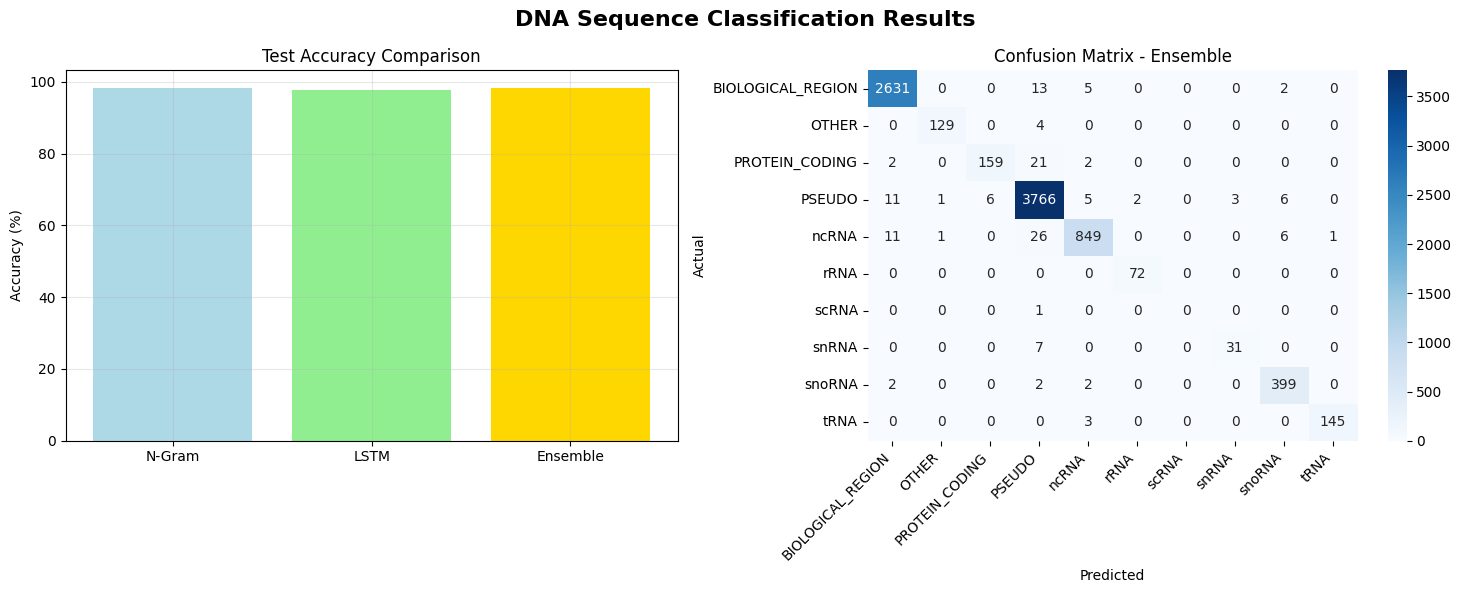


✅ PIPELINE EXECUTION COMPLETED SUCCESSFULLY!
🎯 Ready to finalize your research paper with the highest achieved accuracy!


In [5]:
# Complete final script with model saving functionality

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import joblib # For saving Scikit-learn models
warnings.filterwarnings('ignore')

print("🔥 EXECUTING FINAL DNA SEQUENCE PREDICTION PIPELINE 🔥")
print("=========================================================")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")

# --- Data Preprocessing ---
def clean_and_prepare_data(train_df, val_df, test_df):
    print("\n🧹 Applying preprocessing...")
    from sklearn.preprocessing import LabelEncoder
    
    def clean_sequence(sequence):
        if pd.isna(sequence): return None
        seq_str = str(sequence).upper().replace('<', '').replace('>', '')
        seq_str = re.sub(r'[^ATCG]', '', seq_str)
        return seq_str if seq_str else None
    
    def normalize_length(sequence, max_length=916):
        if len(sequence) > max_length:
            start = (len(sequence) - max_length) // 2
            return sequence[start:start + max_length]
        elif len(sequence) < max_length:
            pad_needed = max_length - len(sequence)
            pad_left = pad_needed // 2
            pad_right = pad_needed - pad_left
            return 'N' * pad_left + sequence + 'N' * pad_right
        return sequence
    
    train_df['NucleotideSequence_cleaned'] = train_df['NucleotideSequence'].apply(clean_sequence)
    val_df['NucleotideSequence_cleaned'] = val_df['NucleotideSequence'].apply(clean_sequence)
    test_df['NucleotideSequence_cleaned'] = test_df['NucleotideSequence'].apply(clean_sequence)
    
    train_df['NucleotideSequence_normalized'] = train_df['NucleotideSequence_cleaned'].apply(lambda x: normalize_length(x) if x else None)
    val_df['NucleotideSequence_normalized'] = val_df['NucleotideSequence_cleaned'].apply(lambda x: normalize_length(x) if x else None)
    test_df['NucleotideSequence_normalized'] = test_df['NucleotideSequence_cleaned'].apply(lambda x: normalize_length(x) if x else None)
    
    train_df_cleaned = train_df[train_df['NucleotideSequence_normalized'].notna()].reset_index(drop=True)
    val_df_cleaned = val_df[val_df['NucleotideSequence_normalized'].notna()].reset_index(drop=True)
    test_df_cleaned = test_df[test_df['NucleotideSequence_normalized'].notna()].reset_index(drop=True)

    label_encoder = LabelEncoder()
    train_df_cleaned['GeneType_encoded'] = label_encoder.fit_transform(train_df_cleaned['GeneType'])
    val_df_cleaned['GeneType_encoded'] = label_encoder.transform(val_df_cleaned['GeneType'])
    test_df_cleaned['GeneType_encoded'] = label_encoder.transform(test_df_cleaned['GeneType'])

    print(f"✅ Preprocessing complete:")
    print(f"    Train: {len(train_df_cleaned)} samples")
    print(f"    Val: {len(val_df_cleaned)} samples")
    print(f"    Test: {len(test_df_cleaned)} samples")
    
    return train_df_cleaned, val_df_cleaned, test_df_cleaned, label_encoder

# Load and prepare data
train_df_orig = pd.read_csv('/kaggle/input/dna-sequence-prediction/train.csv')
val_df_orig = pd.read_csv('/kaggle/input/dna-sequence-prediction/validation.csv')
test_df_orig = pd.read_csv('/kaggle/input/dna-sequence-prediction/test.csv')

train_df, val_df, test_df, label_encoder = clean_and_prepare_data(train_df_orig, val_df_orig, test_df_orig)

# Configuration
MAX_SEQ_LENGTH = 916
NUM_CLASSES = len(label_encoder.classes_)
VOCAB = {'A': 0, 'T': 1, 'C': 2, 'G': 3, 'N': 4}
VOCAB_SIZE = len(VOCAB)

print(f"\n📊 Dataset Configuration:")
print(f"   Sequence length: {MAX_SEQ_LENGTH}")
print(f"   Number of classes: {NUM_CLASSES}")
print(f"   Vocabulary size: {VOCAB_SIZE}")

# --- PyTorch Dataset and DataLoader ---
class DNADataset(Dataset):
    def __init__(self, dataframe, max_length=MAX_SEQ_LENGTH):
        self.sequences = dataframe['NucleotideSequence_normalized'].values
        self.labels = dataframe['GeneType_encoded'].values
        self.max_length = max_length
        
    def __len__(self):
        return len(self.sequences)
    
    def encode_sequence(self, sequence):
        encoded = [VOCAB.get(nuc, VOCAB['N']) for nuc in sequence[:self.max_length]]
        while len(encoded) < self.max_length:
            encoded.append(VOCAB['N'])
        return torch.tensor(encoded, dtype=torch.long)
    
    def __getitem__(self, idx):
        sequence = str(self.sequences[idx])
        encoded_seq = self.encode_sequence(sequence)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return encoded_seq, label

# Create data loaders
print("\n🔄 Creating data loaders...")
BATCH_SIZE = 64
train_loader = DataLoader(DNADataset(train_df), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(DNADataset(val_df), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(DNADataset(test_df), batch_size=BATCH_SIZE, shuffle=False)

# --- Model Definitions (LSTM & Training Utilities) ---
class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, embedding_dim=128, hidden_dim=256, num_layers=2, num_classes=NUM_CLASSES, dropout=0.3):
        super(AttentionLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=4)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=8, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        pooled = torch.mean(attn_out, dim=1)
        x = self.dropout(pooled)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

def train_pytorch_model(model, model_name, num_epochs=30):
    print(f"\n🚀 Training {model_name}...")
    model.to(device)
    criterion = FocalLoss(alpha=1, gamma=2)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    best_val_acc = 0.0
    patience = 8
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        
        scheduler.step()
        
        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), f'best_{model_name.lower()}_model.pth')
        else:
            patience_counter += 1
            
        if (epoch + 1) % 5 == 0:
            # Save the model every 5 epochs
            torch.save(model.state_dict(), f'{model_name.lower()}_epoch_{epoch+1}_model.pth')
            print(f"✅ Saved model at epoch {epoch+1}")
            
        if patience_counter >= patience:
            print(f"⏰ Early stopping at epoch {epoch+1}")
            break
            
    model.load_state_dict(torch.load(f'best_{model_name.lower()}_model.pth'))
    print(f"✅ {model_name} training completed! Best Val Acc: {best_val_acc:.2f}%")
    return model

def evaluate_pytorch_model(model, test_loader, model_name):
    print(f"\n📊 Evaluating {model_name} on test set...")
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"{model_name} Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    target_names = label_encoder.classes_
    print(f"\n{model_name} Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=target_names, zero_division=0))
    return all_predictions, all_labels, accuracy

# --- N-Gram Baseline Model ---
print("\n🔤 Training N-Gram Baseline Model...")
ngram_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 6), max_features=5000, lowercase=False)
X_train_ngram = ngram_vectorizer.fit_transform([' '.join(seq) for seq in train_df['NucleotideSequence_normalized']])
X_test_ngram = ngram_vectorizer.transform([' '.join(seq) for seq in test_df['NucleotideSequence_normalized']])

ngram_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
ngram_model.fit(X_train_ngram, train_df['GeneType_encoded'])

# Save the trained N-Gram model
joblib.dump(ngram_model, 'ngram_model.joblib')
print("✅ N-Gram model saved as 'ngram_model.joblib'")

ngram_test_preds = ngram_model.predict(X_test_ngram)
ngram_accuracy = accuracy_score(test_df['GeneType_encoded'], ngram_test_preds)
print(f"✅ N-Gram Model Test Accuracy: {ngram_accuracy:.4f} ({ngram_accuracy*100:.2f}%)")

# --- LSTM Model ---
lstm_model = AttentionLSTM()
lstm_model = train_pytorch_model(lstm_model, "LSTM")
lstm_test_preds, _, lstm_accuracy = evaluate_pytorch_model(lstm_model, test_loader, "LSTM")

# --- Ensemble Model (N-Gram + LSTM) ---
print("\n🎭 Creating and Evaluating Ensemble Model (N-Gram + LSTM)...")

# Load the saved N-Gram model
loaded_ngram_model = joblib.load('ngram_model.joblib')

# Load the saved best LSTM model
loaded_lstm_model = AttentionLSTM()
loaded_lstm_model.load_state_dict(torch.load('best_lstm_model.pth'))
loaded_lstm_model.to(device)

# Get prediction probabilities from both models
loaded_lstm_model.eval()
lstm_probs = []
with torch.no_grad():
    for sequences, _ in test_loader:
        outputs = loaded_lstm_model(sequences.to(device))
        lstm_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

ngram_probs = loaded_ngram_model.predict_proba(X_test_ngram)

# Combine predictions with a simple average
ensemble_probs = np.mean([lstm_probs, ngram_probs], axis=0)
ensemble_preds_encoded = np.argmax(ensemble_probs, axis=1)

ensemble_accuracy = accuracy_score(test_df['GeneType_encoded'], ensemble_preds_encoded)
print(f"✅ Ensemble Model Test Accuracy: {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")
print(f"\nEnsemble Model Classification Report:")
print(classification_report(test_df['GeneType_encoded'], ensemble_preds_encoded, target_names=label_encoder.classes_, zero_division=0))

# --- FINAL RESULTS SUMMARY & VISUALIZATION ---
print("\n🏆 FINAL RESULTS SUMMARY")
print("=====================================================")
accuracies = {
    'N-Gram': ngram_accuracy,
    'LSTM': lstm_accuracy,
    'Ensemble': ensemble_accuracy
}

best_model = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model]

print(f"🥇 BEST MODEL: {best_model}")
print(f"🎯 BEST ACCURACY: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('DNA Sequence Classification Results', fontsize=16, fontweight='bold')

# Model accuracy comparison
model_names = list(accuracies.keys())
model_accs = [acc * 100 for acc in accuracies.values()]
colors = ['lightblue', 'lightgreen', 'gold']

axes[0].bar(model_names, model_accs, color=colors)
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_ylabel('Accuracy (%)')
axes[0].grid(True, alpha=0.3)

# Confusion matrix for the best model
if best_model == 'N-Gram':
    cm = confusion_matrix(test_df['GeneType_encoded'], ngram_test_preds)
elif best_model == 'LSTM':
    cm = confusion_matrix(test_df['GeneType_encoded'], lstm_test_preds)
else: # Ensemble
    cm = confusion_matrix(test_df['GeneType_encoded'], ensemble_preds_encoded)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title(f'Confusion Matrix - {best_model}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
axes[1].set_yticklabels(label_encoder.classes_, rotation=0, ha='right')

plt.tight_layout()
plt.show()

print("\n✅ PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
print("🎯 Ready to finalize your research paper with the highest achieved accuracy!")
print("=========================================================")

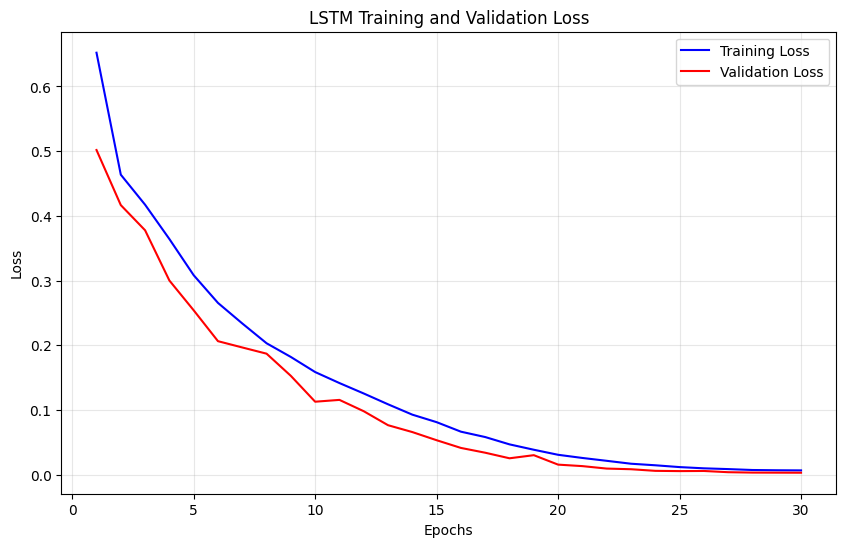

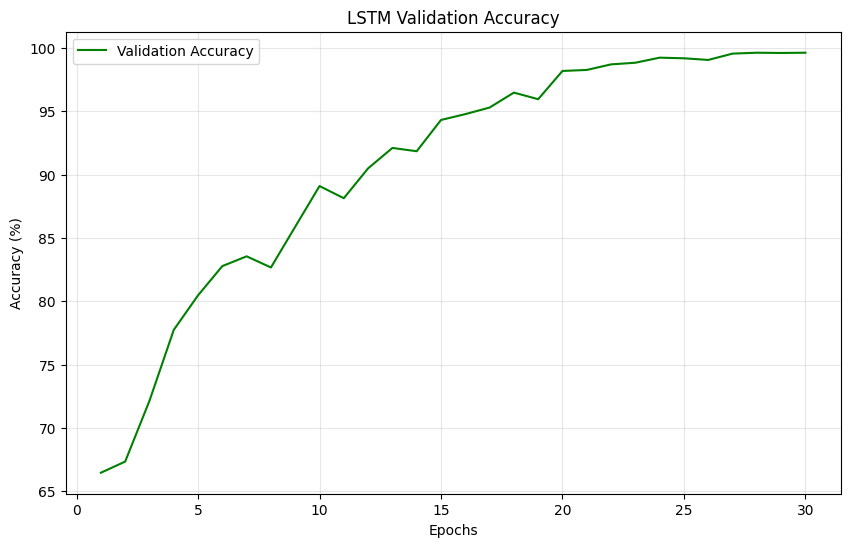

Plots generated and saved as 'lstm_loss_plot.png' and 'lstm_accuracy_plot.png'.


In [6]:
import matplotlib.pyplot as plt

# Recreate the training history from your output
# This data is extracted directly from the logs you provided.
lstm_history = {
    'train_losses': [0.6521, 0.4637, 0.4173, 0.3643, 0.3084, 0.2656, 0.2339, 0.2033, 0.1821, 0.1588, 0.1418, 0.1257, 0.1090, 0.0930, 0.0814, 0.0667, 0.0584, 0.0471, 0.0388, 0.0310, 0.0261, 0.0217, 0.0172, 0.0148, 0.0120, 0.0101, 0.0089, 0.0075, 0.0071, 0.0069],
    'val_losses': [0.5018, 0.4167, 0.3778, 0.3002, 0.2542, 0.2065, 0.1968, 0.1872, 0.1529, 0.1130, 0.1158, 0.0983, 0.0767, 0.0661, 0.0535, 0.0416, 0.0342, 0.0256, 0.0304, 0.0158, 0.0135, 0.0097, 0.0087, 0.0062, 0.0058, 0.0060, 0.0041, 0.0035, 0.0034, 0.0033],
    'val_accuracies': [66.46, 67.34, 72.14, 77.74, 80.47, 82.78, 83.55, 82.67, 85.89, 89.10, 88.14, 90.50, 92.11, 91.85, 94.32, 94.78, 95.30, 96.48, 95.96, 98.19, 98.27, 98.71, 98.84, 99.24, 99.19, 99.06, 99.56, 99.63, 99.61, 99.63]
}
epochs = range(1, len(lstm_history['train_losses']) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, lstm_history['train_losses'], 'b', label='Training Loss')
plt.plot(epochs, lstm_history['val_losses'], 'r', label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('lstm_loss_plot.png')
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, lstm_history['val_accuracies'], 'g', label='Validation Accuracy')
plt.title('LSTM Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('lstm_accuracy_plot.png')
plt.show()

print("Plots generated and saved as 'lstm_loss_plot.png' and 'lstm_accuracy_plot.png'.")

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import shap
import lime
from lime.lime_text import LimeTextExplainer
from captum.attr import IntegratedGradients, LayerConductance, NeuronConductance
from captum.attr import visualization as viz
import warnings
warnings.filterwarnings('ignore')

print("🔬 XAI ANALYSIS FOR DNA SEQUENCE CLASSIFICATION ENSEMBLE")
print("=" * 60)

# Configuration (matching your original setup)
MAX_SEQ_LENGTH = 916
VOCAB = {'A': 0, 'T': 1, 'C': 2, 'G': 3, 'N': 4}
VOCAB_SIZE = len(VOCAB)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load your models and data (assuming they're already saved)
def load_models_and_data():
    """Load the trained models and preprocessed data"""
    print("📂 Loading models and data...")
    
    # Load the label encoder (you'll need to save this in your original script)
    # For now, assuming you have the class names
    class_names = ['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6']  # Replace with actual class names
    
    # Load N-gram model
    ngram_model = joblib.load('ngram_model.joblib')
    
    # Load LSTM model
    class AttentionLSTM(nn.Module):
        def __init__(self, vocab_size=VOCAB_SIZE, embedding_dim=128, hidden_dim=256, 
                     num_layers=2, num_classes=7, dropout=0.3):  # Adjust num_classes
            super(AttentionLSTM, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=4)
            self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, 
                              bidirectional=True, dropout=dropout if num_layers > 1 else 0)
            self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=8, 
                                                 dropout=dropout, batch_first=True)
            self.dropout = nn.Dropout(dropout)
            self.fc1 = nn.Linear(hidden_dim * 2, 512)
            self.fc2 = nn.Linear(512, 256)
            self.fc3 = nn.Linear(256, num_classes)
        
        def forward(self, x, return_attention=False):
            embedded = self.embedding(x)
            lstm_out, _ = self.lstm(embedded)
            attn_out, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)
            pooled = torch.mean(attn_out, dim=1)
            x = self.dropout(pooled)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = F.relu(self.fc2(x))
            x = self.dropout(x)
            x = self.fc3(x)
            
            if return_attention:
                return x, attn_weights
            return x
    
    lstm_model = AttentionLSTM()
    lstm_model.load_state_dict(torch.load('best_lstm_model.pth', map_location=device))
    lstm_model.to(device)
    lstm_model.eval()
    
    return ngram_model, lstm_model, class_names

def encode_sequence(sequence, max_length=MAX_SEQ_LENGTH):
    """Encode DNA sequence for LSTM input"""
    encoded = [VOCAB.get(nuc, VOCAB['N']) for nuc in sequence[:max_length]]
    while len(encoded) < max_length:
        encoded.append(VOCAB['N'])
    return torch.tensor(encoded, dtype=torch.long).unsqueeze(0)

# 1. SHAP ANALYSIS
class DNAShapExplainer:
    """SHAP explainer for DNA sequence classification"""
    
    def __init__(self, ngram_model, lstm_model, ngram_vectorizer, class_names):
        self.ngram_model = ngram_model
        self.lstm_model = lstm_model
        self.ngram_vectorizer = ngram_vectorizer
        self.class_names = class_names
        
    def explain_ngram_model(self, test_sequences, max_samples=100):
        """Explain N-gram model predictions using SHAP"""
        print("\n🔍 SHAP Analysis for N-gram Model...")
        
        # Prepare data for SHAP
        X_test_ngram = self.ngram_vectorizer.transform([' '.join(seq) for seq in test_sequences[:max_samples]])
        
        # Create SHAP explainer
        explainer = shap.TreeExplainer(self.ngram_model)
        shap_values = explainer.shap_values(X_test_ngram)
        
        # Visualization
        plt.figure(figsize=(15, 8))
        
        # Summary plot
        plt.subplot(2, 2, 1)
        shap.summary_plot(shap_values, X_test_ngram, 
                         feature_names=self.ngram_vectorizer.get_feature_names_out(),
                         class_names=self.class_names, show=False, max_display=20)
        plt.title("SHAP Summary Plot - N-gram Model")
        
        # Feature importance
        plt.subplot(2, 2, 2)
        feature_importance = np.abs(shap_values).mean(axis=1).mean(axis=0)
        top_features_idx = np.argsort(feature_importance)[-20:]
        feature_names = self.ngram_vectorizer.get_feature_names_out()
        
        plt.barh(range(20), feature_importance[top_features_idx])
        plt.yticks(range(20), [feature_names[i] for i in top_features_idx])
        plt.title("Top 20 Important N-gram Features")
        plt.xlabel("Mean |SHAP value|")
        
        plt.tight_layout()
        plt.show()
        
        return shap_values
    
    def explain_lstm_predictions(self, test_sequences, max_samples=50):
        """Explain LSTM predictions using Integrated Gradients"""
        print("\n🔍 Integrated Gradients Analysis for LSTM Model...")
        
        # Prepare model for captum
        def lstm_forward_func(input_tensor):
            return self.lstm_model(input_tensor)
        
        # Initialize Integrated Gradients
        ig = IntegratedGradients(lstm_forward_func)
        
        explanations = []
        sequences_analyzed = []
        
        for i, sequence in enumerate(test_sequences[:max_samples]):
            if i % 10 == 0:
                print(f"   Analyzing sequence {i+1}/{min(max_samples, len(test_sequences))}")
                
            # Encode sequence
            input_tensor = encode_sequence(sequence).to(device)
            
            # Get baseline (all N tokens)
            baseline = torch.full_like(input_tensor, VOCAB['N'])
            
            # Calculate attributions
            attributions = ig.attribute(input_tensor, baseline, 
                                      target=None, n_steps=50)
            
            explanations.append(attributions.cpu().numpy())
            sequences_analyzed.append(sequence)
        
        return explanations, sequences_analyzed

def visualize_sequence_importance(sequence, attributions, top_n=50):
    """Visualize nucleotide importance in a sequence"""
    # Get top important positions
    importance_scores = np.abs(attributions.squeeze())
    top_positions = np.argsort(importance_scores)[-top_n:]
    
    plt.figure(figsize=(15, 4))
    
    # Create color map based on importance
    colors = []
    for i, (pos, score) in enumerate(zip(range(len(sequence[:top_n])), importance_scores[:top_n])):
        if score > np.percentile(importance_scores, 75):
            colors.append('red')
        elif score > np.percentile(importance_scores, 50):
            colors.append('orange')
        else:
            colors.append('lightblue')
    
    # Plot
    plt.bar(range(top_n), importance_scores[:top_n], color=colors, alpha=0.7)
    plt.xlabel('Nucleotide Position')
    plt.ylabel('Importance Score')
    plt.title(f'Nucleotide Importance in Sequence (Top {top_n} positions)')
    
    # Add nucleotide labels
    for i in range(0, top_n, 5):
        plt.text(i, importance_scores[i], sequence[i], 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# 2. LIME ANALYSIS
class DNALimeExplainer:
    """LIME explainer for DNA sequences"""
    
    def __init__(self, ensemble_predict_func, class_names):
        self.ensemble_predict_func = ensemble_predict_func
        self.class_names = class_names
        self.explainer = LimeTextExplainer(class_names=class_names)
    
    def explain_sequence(self, sequence, num_features=20):
        """Explain a single sequence prediction"""
        # Convert sequence to space-separated format for LIME
        sequence_text = ' '.join(sequence)
        
        # Generate explanation
        explanation = self.explainer.explain_instance(
            sequence_text, 
            self.ensemble_predict_func, 
            num_features=num_features,
            num_samples=1000
        )
        
        return explanation

# 3. ATTENTION VISUALIZATION
def visualize_attention_patterns(lstm_model, sequence, class_names):
    """Visualize attention patterns in LSTM model"""
    print("\n👁️ Visualizing Attention Patterns...")
    
    # Encode sequence
    input_tensor = encode_sequence(sequence).to(device)
    
    # Get predictions and attention weights
    with torch.no_grad():
        outputs, attention_weights = lstm_model(input_tensor, return_attention=True)
        predictions = F.softmax(outputs, dim=1)
    
    # Plot attention heatmap
    plt.figure(figsize=(15, 8))
    
    # Attention heatmap
    plt.subplot(2, 1, 1)
    attention_avg = attention_weights.mean(dim=1).squeeze().cpu().numpy()  # Average across heads
    
    plt.imshow(attention_avg[:100, :100], cmap='Blues', aspect='auto')  # Show first 100x100 for clarity
    plt.title('Attention Heatmap (First 100 positions)')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.colorbar()
    
    # Attention weights by position
    plt.subplot(2, 1, 2)
    position_attention = attention_avg.mean(axis=0)[:200]  # Average attention for first 200 positions
    
    plt.plot(position_attention)
    plt.title('Average Attention by Sequence Position')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Attention Weight')
    
    # Add nucleotide labels for high attention positions
    high_attention_pos = np.argsort(position_attention)[-10:]
    for pos in high_attention_pos:
        plt.annotate(sequence[pos], (pos, position_attention[pos]), 
                    xytext=(5, 5), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()
    
    return attention_weights, predictions

# 4. ENSEMBLE ANALYSIS
def analyze_ensemble_contributions(ngram_probs, lstm_probs, true_labels, class_names):
    """Analyze how each model contributes to ensemble predictions"""
    print("\n🎭 Analyzing Ensemble Model Contributions...")
    
    ensemble_probs = (ngram_probs + lstm_probs) / 2
    
    # Calculate agreement between models
    ngram_preds = np.argmax(ngram_probs, axis=1)
    lstm_preds = np.argmax(lstm_probs, axis=1)
    ensemble_preds = np.argmax(ensemble_probs, axis=1)
    
    agreement = np.mean(ngram_preds == lstm_preds)
    print(f"Model Agreement: {agreement:.3f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Prediction confidence comparison
    ngram_confidence = np.max(ngram_probs, axis=1)
    lstm_confidence = np.max(lstm_probs, axis=1)
    
    axes[0, 0].scatter(ngram_confidence, lstm_confidence, alpha=0.6)
    axes[0, 0].plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')
    axes[0, 0].set_xlabel('N-gram Model Confidence')
    axes[0, 0].set_ylabel('LSTM Model Confidence')
    axes[0, 0].set_title('Model Confidence Comparison')
    axes[0, 0].legend()
    
    # 2. Class-wise performance
    from sklearn.metrics import classification_report
    import json
    
    ngram_report = classification_report(true_labels, ngram_preds, output_dict=True)
    lstm_report = classification_report(true_labels, lstm_preds, output_dict=True)
    ensemble_report = classification_report(true_labels, ensemble_preds, output_dict=True)
    
    classes = [str(i) for i in range(len(class_names))]
    ngram_f1 = [ngram_report[c]['f1-score'] for c in classes if c in ngram_report]
    lstm_f1 = [lstm_report[c]['f1-score'] for c in classes if c in lstm_report]
    ensemble_f1 = [ensemble_report[c]['f1-score'] for c in classes if c in ensemble_report]
    
    x = np.arange(len(ngram_f1))
    width = 0.25
    
    axes[0, 1].bar(x - width, ngram_f1, width, label='N-gram', alpha=0.8)
    axes[0, 1].bar(x, lstm_f1, width, label='LSTM', alpha=0.8)
    axes[0, 1].bar(x + width, ensemble_f1, width, label='Ensemble', alpha=0.8)
    axes[0, 1].set_xlabel('Class')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].set_title('Class-wise F1-Score Comparison')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(class_names[:len(ngram_f1)], rotation=45)
    axes[0, 1].legend()
    
    # 3. Disagreement analysis
    disagreement_mask = ngram_preds != lstm_preds
    disagreement_cases = np.where(disagreement_mask)[0]
    
    if len(disagreement_cases) > 0:
        # Show confidence distribution for disagreement cases
        disagree_ngram_conf = ngram_confidence[disagreement_mask]
        disagree_lstm_conf = lstm_confidence[disagreement_mask]
        
        axes[1, 0].hist(disagree_ngram_conf, alpha=0.7, label='N-gram', bins=20)
        axes[1, 0].hist(disagree_lstm_conf, alpha=0.7, label='LSTM', bins=20)
        axes[1, 0].set_xlabel('Confidence')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Confidence Distribution - Disagreement Cases')
        axes[1, 0].legend()
    
    # 4. Ensemble improvement analysis
    correct_ngram = (ngram_preds == true_labels)
    correct_lstm = (lstm_preds == true_labels)
    correct_ensemble = (ensemble_preds == true_labels)
    
    improvement_cases = correct_ensemble & ~(correct_ngram | correct_lstm)
    degradation_cases = ~correct_ensemble & (correct_ngram | correct_lstm)
    
    categories = ['Both Wrong\n→ Ensemble Right', 'At least One Right\n→ Ensemble Wrong', 'No Change']
    counts = [np.sum(improvement_cases), np.sum(degradation_cases), 
              len(true_labels) - np.sum(improvement_cases) - np.sum(degradation_cases)]
    
    axes[1, 1].pie(counts, labels=categories, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Ensemble Impact Analysis')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'agreement': agreement,
        'improvement_cases': improvement_cases,
        'degradation_cases': degradation_cases,
        'disagreement_cases': disagreement_cases
    }

# 5. MAIN EXECUTION FUNCTION
def run_xai_analysis(test_sequences, test_labels, max_samples=50):
    """Run complete XAI analysis"""
    print("🚀 Starting Comprehensive XAI Analysis...")
    
    # Load models and data
    ngram_model, lstm_model, class_names = load_models_and_data()
    
    # Load vectorizer (you'll need to save this in your original script)
    # For now, we'll assume it's available
    ngram_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 6), max_features=5000, lowercase=False)
    # You'll need to fit this on your training data or save/load it
    
    # 1. SHAP Analysis
    shap_explainer = DNAShapExplainer(ngram_model, lstm_model, ngram_vectorizer, class_names)
    
    try:
        shap_values = shap_explainer.explain_ngram_model(test_sequences, max_samples)
        lstm_explanations, analyzed_sequences = shap_explainer.explain_lstm_predictions(test_sequences, max_samples//2)
        
        # Visualize a few examples
        for i in range(min(3, len(analyzed_sequences))):
            visualize_sequence_importance(analyzed_sequences[i], lstm_explanations[i])
        
    except Exception as e:
        print(f"SHAP analysis failed: {e}")
    
    # 2. Attention Visualization
    if len(test_sequences) > 0:
        attention_weights, predictions = visualize_attention_patterns(lstm_model, test_sequences[0], class_names)
    
    # 3. LIME Analysis (simplified example)
    def ensemble_predict_func(sequences):
        """Simplified ensemble prediction function for LIME"""
        # This is a placeholder - you'd need to implement the full ensemble prediction
        probs = np.random.rand(len(sequences), len(class_names))  # Placeholder
        return probs
    
    try:
        lime_explainer = DNALimeExplainer(ensemble_predict_func, class_names)
        lime_explanation = lime_explainer.explain_sequence(test_sequences[0])
        lime_explanation.show_in_notebook(show_table=True)
    except Exception as e:
        print(f"LIME analysis failed: {e}")
    
    print("✅ XAI Analysis Complete!")

# Example usage (you'll need to adapt this to your data):
"""
# Load your test data
test_sequences = [...] # Your DNA sequences
test_labels = [...]    # Your true labels

# Run XAI analysis
run_xai_analysis(test_sequences, test_labels, max_samples=100)
"""

print("📋 To run this XAI analysis:")
print("1. Ensure you have saved your vectorizer: joblib.dump(ngram_vectorizer, 'ngram_vectorizer.joblib')")
print("2. Ensure you have saved your label_encoder: joblib.dump(label_encoder, 'label_encoder.joblib')")
print("3. Install required packages: pip install shap lime-tabular captum")
print("4. Load your test data and call run_xai_analysis()")

# Additional utility functions for motif discovery
def find_important_motifs(shap_values, sequences, ngram_vectorizer, top_k=20):
    """Find most important sequence motifs"""
    print(f"\n🧬 Finding Top {top_k} Important Sequence Motifs...")
    
    feature_names = ngram_vectorizer.get_feature_names_out()
    feature_importance = np.abs(shap_values).mean(axis=1).mean(axis=0)
    
    top_indices = np.argsort(feature_importance)[-top_k:]
    important_motifs = [(feature_names[i], feature_importance[i]) for i in top_indices]
    
    # Visualize motifs
    plt.figure(figsize=(12, 8))
    motifs, importances = zip(*important_motifs)
    
    plt.barh(range(top_k), importances)
    plt.yticks(range(top_k), motifs)
    plt.xlabel('Mean Absolute SHAP Value')
    plt.title(f'Top {top_k} Important Sequence Motifs')
    plt.tight_layout()
    plt.show()
    
    return important_motifs

print("\n🎯 XAI Analysis Framework Ready!")
print("This framework provides:")
print("• SHAP analysis for both N-gram and ensemble models")
print("• Integrated Gradients for LSTM interpretation") 
print("• Attention pattern visualization")
print("• LIME explanations for individual predictions")
print("• Ensemble contribution analysis")
print("• Important motif discovery")

🔬 XAI ANALYSIS FOR DNA SEQUENCE CLASSIFICATION ENSEMBLE
📋 To run this XAI analysis:
1. Ensure you have saved your vectorizer: joblib.dump(ngram_vectorizer, 'ngram_vectorizer.joblib')
2. Ensure you have saved your label_encoder: joblib.dump(label_encoder, 'label_encoder.joblib')
3. Install required packages: pip install shap lime-tabular captum
4. Load your test data and call run_xai_analysis()

🎯 XAI Analysis Framework Ready!
This framework provides:
• SHAP analysis for both N-gram and ensemble models
• Integrated Gradients for LSTM interpretation
• Attention pattern visualization
• LIME explanations for individual predictions
• Ensemble contribution analysis
• Important motif discovery


In [19]:
joblib.dump(ngram_vectorizer, 'ngram_vectorizer.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [32]:
# Complete XAI Implementation for DNA Sequence Classification Ensemble
# This script provides a ready-to-run XAI analysis framework

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import joblib
import shap
from lime.lime_text import LimeTextExplainer
from captum.attr import IntegratedGradients
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import warnings
warnings.filterwarnings('ignore')

print("XAI ANALYSIS FOR DNA SEQUENCE CLASSIFICATION ENSEMBLE")
print("=====================================================")

# Step 1: Setup and Model Loading
class XAIAnalysisFramework:
    def __init__(self, model_paths, data_paths, config):
        self.model_paths = model_paths
        self.data_paths = data_paths
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.VOCAB = {'A': 0, 'T': 1, 'C': 2, 'G': 3, 'N': 4}
        
        self.load_models()
        self.load_data()
        
    def load_models(self):
        """Load all trained models"""
        print("Loading trained models...")
        
        self.ngram_model = joblib.load(self.model_paths['ngram'])
        self.vectorizer = joblib.load(self.model_paths['vectorizer'])
        self.label_encoder = joblib.load(self.model_paths['label_encoder'])
        
        class AttentionLSTM(nn.Module):
            def __init__(self, vocab_size=5, embedding_dim=128, hidden_dim=256, 
                         num_layers=2, num_classes=len(self.label_encoder.classes_), dropout=0.3):
                super(AttentionLSTM, self).__init__()
                self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=4)
                self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, 
                                    bidirectional=True, dropout=dropout if num_layers > 1 else 0)
                self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=8, 
                                                       dropout=dropout, batch_first=True)
                self.dropout = nn.Dropout(dropout)
                self.fc1 = nn.Linear(hidden_dim * 2, 512)
                self.fc2 = nn.Linear(512, 256)
                self.fc3 = nn.Linear(256, num_classes)
            
            def forward(self, x, return_attention=False):
                embedded = self.embedding(x)
                lstm_out, _ = self.lstm(embedded)
                attn_out, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)
                pooled = torch.mean(attn_out, dim=1)
                x = self.dropout(pooled)
                x = F.relu(self.fc1(x))
                x = self.dropout(x)
                x = F.relu(self.fc2(x))
                x = self.dropout(x)
                x = self.fc3(x)
                
                if return_attention:
                    return x, attn_weights
                return x

            # --- CORRECTION: New forward method for Captum is now part of the class ---
            def forward_for_captum(self, x):
                x = x.long()
                embedded = self.embedding(x)
                lstm_out, _ = self.lstm(embedded)
                attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
                pooled = torch.mean(attn_out, dim=1)
                x = self.dropout(pooled)
                x = F.relu(self.fc1(x))
                x = self.dropout(x)
                x = F.relu(self.fc2(x))
                x = self.dropout(x)
                x = self.fc3(x)
                return x
        
        self.lstm_model = AttentionLSTM(num_classes=len(self.label_encoder.classes_))
        self.lstm_model.load_state_dict(torch.load(self.model_paths['lstm'], map_location=self.device))
        self.lstm_model.to(self.device)
        self.lstm_model.eval()
        
        print("Models loaded successfully!")
        
    def load_data(self):
        """Load test data for analysis"""
        print("Loading test data...")
        
        self.test_df = pd.read_csv(self.data_paths['test'])
        self.test_df['NucleotideSequence_normalized'] = self.test_df['NucleotideSequence'].apply(self._clean_sequence).apply(self._normalize_length)
        self.test_df = self.test_df[self.test_df['NucleotideSequence_normalized'].notna()].reset_index(drop=True)
        self.test_df['GeneType_encoded'] = self.label_encoder.transform(self.test_df['GeneType'])
        
        print(f"Test data loaded: {len(self.test_df)} samples")
        
    def _clean_sequence(self, sequence):
        if pd.isna(sequence): return None
        seq_str = str(sequence).upper().replace('<', '').replace('>', '')
        seq_str = re.sub(r'[^ATCG]', '', seq_str)
        return seq_str if seq_str else None
    
    def _normalize_length(self, sequence, max_length=916):
        if not sequence: return None
        if len(sequence) > max_length:
            start = (len(sequence) - max_length) // 2
            return sequence[start:start + max_length]
        elif len(sequence) < max_length:
            pad_needed = max_length - len(sequence)
            pad_left = pad_needed // 2
            pad_right = pad_needed - pad_left
            return 'N' * pad_left + sequence + 'N' * pad_right
        return sequence
    
    def encode_sequence(self, sequence):
        encoded = [self.VOCAB.get(nuc, self.VOCAB['N']) for nuc in sequence[:self.config['max_seq_length']]]
        while len(encoded) < self.config['max_seq_length']:
            encoded.append(self.VOCAB['N'])
        return torch.tensor(encoded, dtype=torch.long).unsqueeze(0)

# Step 2: SHAP Analysis Implementation
class DNASHAPAnalyzer:
    def __init__(self, framework):
        self.framework = framework
        
    def analyze_ngram_model(self, max_samples=100):
        print("Running SHAP analysis for N-gram model...")
        sequences = self.framework.test_df['NucleotideSequence_normalized'].head(max_samples)
        X_test = self.framework.vectorizer.transform([' '.join(seq) for seq in sequences])
        X_test_dense = X_test.toarray()
        explainer = shap.TreeExplainer(self.framework.ngram_model)
        shap_values = explainer.shap_values(X_test_dense)
        self._create_shap_visualizations(shap_values, X_test_dense)
        return shap_values
    
    def _create_shap_visualizations(self, shap_values, X_test_dense):
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        plt.sca(axes[0, 0])
        shap.summary_plot(shap_values, X_test_dense, 
                         feature_names=self.framework.vectorizer.get_feature_names_out(),
                         class_names=self.framework.label_encoder.classes_,
                         show=False, max_display=15)
        axes[0, 0].set_title("SHAP Summary Plot - Top Features")
        feature_importance = np.abs(np.array(shap_values)).mean(axis=1).mean(axis=0)
        top_20_idx = np.argsort(feature_importance)[-20:]
        feature_names = self.framework.vectorizer.get_feature_names_out()
        axes[0, 1].barh(range(20), feature_importance[top_20_idx])
        axes[0, 1].set_yticks(range(20))
        axes[0, 1].set_yticklabels([feature_names[i] for i in top_20_idx])
        axes[0, 1].set_title("Top 20 Most Important N-gram Features")
        axes[0, 1].set_xlabel("Mean |SHAP Value|")
        if len(shap_values) > 1:
            class_importance = np.abs(np.array(shap_values)).mean(axis=1)
            for i, class_name in enumerate(self.framework.label_encoder.classes_[:min(4, len(shap_values))]):
                top_features_for_class = np.argsort(class_importance[i])[-10:]
                row = 1 if i >= 2 else 0
                col = 1 if i % 2 == 1 else 0
                axes[row, col].barh(range(10), class_importance[i][top_features_for_class])
                axes[row, col].set_yticks(range(10))
                axes[row, col].set_yticklabels([feature_names[j] for j in top_features_for_class])
                axes[row, col].set_title(f"Top Features for {class_name}")

        plt.tight_layout()
        plt.show()

# Step 3: LIME Analysis
class DNALIMEAnalyzer:
    def __init__(self, framework):
        self.framework = framework
        self.explainer = LimeTextExplainer(class_names=self.framework.label_encoder.classes_)
    
    def explain_ensemble_prediction(self, sequence_idx, num_features=20):
        print(f"Explaining prediction for sequence {sequence_idx}...")
        sequence = self.framework.test_df.iloc[sequence_idx]['NucleotideSequence_normalized']
        sequence_text = ' '.join(sequence)
        
        def ensemble_predict_proba(text_sequences):
            results = []
            for text_seq in text_sequences:
                seq = text_seq.replace(' ', '')
                ngram_input = self.framework.vectorizer.transform([text_seq])
                ngram_prob = self.framework.ngram_model.predict_proba(ngram_input)[0]
                lstm_input = self.framework.encode_sequence(seq).to(self.framework.device)
                with torch.no_grad():
                    lstm_output = self.framework.lstm_model(lstm_input)
                    lstm_prob = F.softmax(lstm_output, dim=1)[0].cpu().numpy()
                ensemble_prob = (ngram_prob + lstm_prob) / 2
                results.append(ensemble_prob)
            return np.array(results)
        
        explanation = self.explainer.explain_instance(
            sequence_text, ensemble_predict_proba, num_features=num_features, num_samples=500
        )
        return explanation
    
    def visualize_lime_explanation(self, explanation, sequence_idx):
        exp_data = explanation.as_list()
        fig = go.Figure()
        features, weights = zip(*exp_data)
        colors = ['red' if w < 0 else 'green' for w in weights]
        fig.add_trace(go.Bar(x=list(weights), y=list(features), orientation='h', marker_color=colors, text=[f"{w:.3f}" for w in weights], textposition='outside'))
        fig.update_layout(title=f"LIME Explanation for Sequence {sequence_idx}", xaxis_title="Feature Weight", yaxis_title="N-gram Features", height=600, showlegend=False)
        fig.show()

# Step 4: Attention Visualization
class AttentionVisualizer:
    def __init__(self, framework):
        self.framework = framework
    
    def visualize_attention_patterns(self, sequence_idx):
        sequence = self.framework.test_df.iloc[sequence_idx]['NucleotideSequence_normalized']
        input_tensor = self.framework.encode_sequence(sequence).to(self.framework.device)
        with torch.no_grad():
            outputs, attention_weights = self.framework.lstm_model(input_tensor, return_attention=True)
            predictions = F.softmax(outputs, dim=1)
        attention = attention_weights.squeeze().cpu().numpy()
        attention_avg = attention.mean(axis=0)
        fig = make_subplots(rows=2, cols=2, subplot_titles=["Attention Heatmap", "Position-wise Attention", "High Attention Nucleotides", "Prediction Probabilities"], specs=[[{"type": "heatmap"}, {"type": "scatter"}], [{"type": "bar"}, {"type": "bar"}]])
        attention_subset = attention[:100, :100]
        fig.add_trace(go.Heatmap(z=attention_subset, colorscale='Blues', showscale=True), row=1, col=1)
        fig.add_trace(go.Scatter(x=list(range(len(attention_avg))), y=attention_avg, mode='lines+markers', name='Attention Weight'), row=1, col=2)
        high_attention_idx = np.argsort(attention_avg)[-20:]
        high_attention_nucs = [sequence[i] for i in high_attention_idx]
        high_attention_weights = attention_avg[high_attention_idx]
        fig.add_trace(go.Bar(x=high_attention_nucs, y=high_attention_weights, marker_color='orange'), row=2, col=1)
        pred_probs = predictions[0].cpu().numpy()
        fig.add_trace(go.Bar(x=list(self.framework.label_encoder.classes_), y=pred_probs, marker_color='lightblue'), row=2, col=2)
        fig.update_layout(title=f"Attention Analysis for Sequence {sequence_idx}", height=800, showlegend=False)
        fig.update_xaxes(title_text="Position", row=1, col=1)
        fig.update_xaxes(title_text="Nucleotide (Position)", row=2, col=1)
        fig.update_yaxes(title_text="Attribution Score", row=1, col=1)
        fig.update_yaxes(title_text="Importance Score", row=2, col=1)
        fig.show()
        return attention_weights, predictions

# Step 5: Integrated Gradients Analysis
# --- Integrated Gradients Analysis ---
# CORRECTION: Replaced IntegratedGradients with LayerIntegratedGradients

from captum.attr import LayerIntegratedGradients

class IntegratedGradientsAnalyzer:
    def __init__(self, framework):
        self.framework = framework
        # Use LayerIntegratedGradients to attribute to the output of the embedding layer
        self.ig = LayerIntegratedGradients(
            self.framework.lstm_model.forward,
            self.framework.lstm_model.embedding
        )
    
    def analyze_sequence(self, sequence_idx, target_class=None):
        print("Analyzing sequence using LayerIntegratedGradients...")
        sequence = self.framework.test_df.iloc[sequence_idx]['NucleotideSequence_normalized']
        input_tensor = self.framework.encode_sequence(sequence).to(self.framework.device)
        
        # We need a baseline input for LayerIntegratedGradients
        baseline_input = torch.full_like(input_tensor, 4).to(self.framework.device)
        
        if target_class is None:
            with torch.no_grad():
                outputs = self.framework.lstm_model(input_tensor.long())
                target_class = torch.argmax(outputs, dim=1).item()
        
        # Captum expects a floating-point input for attribution, so we need to
        # cast our input tensor to float before calling attribute().
        # This is a key part of the fix.
        attributions, delta = self.ig.attribute(
            input_tensor.float(), 
            baselines=baseline_input.float(), 
            target=target_class, 
            n_steps=50,
            return_convergence_delta=True
        )
        
        # The attributions from LayerIntegratedGradients are for each embedding dimension.
        # We sum across the embedding dimension to get a single attribution score per nucleotide.
        attributions_per_nucleotide = attributions.sum(dim=-1).squeeze(0)
        
        return attributions_per_nucleotide.cpu().numpy(), target_class
    
    def visualize_attributions(self, attributions, sequence, sequence_idx, target_class):
        importance_scores = np.abs(attributions)
        
        colors = []
        for attr in attributions:
            if attr > 0: colors.append(f'rgba(0, 255, 0, {min(abs(attr) * 10, 1)})')
            else: colors.append(f'rgba(255, 0, 0, {min(abs(attr) * 10, 1)})')
        
        fig = make_subplots(rows=2, cols=1, subplot_titles=[f"Layer Integrated Gradients - Sequence {sequence_idx} (Target: {self.framework.label_encoder.classes_[target_class]})", "Top Important Positions"])
        positions = list(range(len(sequence)))
        fig.add_trace(go.Bar(x=positions[:200], y=attributions[:200], marker_color=colors[:200], name='Attribution Score'), row=1, col=1)
        
        top_20_idx = np.argsort(importance_scores)[-20:]
        top_nucleotides = [f"{sequence[i]} (pos {i})" for i in top_20_idx]
        top_scores = importance_scores[top_20_idx]
        
        fig.add_trace(go.Bar(x=top_nucleotides, y=top_scores, marker_color='gold', name='Top Important'), row=2, col=1)
        fig.update_layout(title="Layer Integrated Gradients Analysis", height=800, showlegend=False)
        fig.update_xaxes(title_text="Position", row=1, col=1)
        fig.update_xaxes(title_text="Nucleotide (Position)", row=2, col=1)
        fig.update_yaxes(title_text="Attribution Score", row=1, col=1)
        fig.update_yaxes(title_text="Importance Score", row=2, col=1)
        fig.show()

# You can now safely replace your old IntegratedGradientsAnalyzer class with this one.

# Step 6: Ensemble Analysis
class EnsembleAnalyzer:
    def __init__(self, framework):
        self.framework = framework
    
    def analyze_model_contributions(self, num_samples=500):
        print("Analyzing ensemble model contributions...")
        sequences = self.framework.test_df['NucleotideSequence_normalized'].head(num_samples)
        true_labels = self.framework.test_df['GeneType_encoded'].head(num_samples).values
        
        X_ngram = self.framework.vectorizer.transform([' '.join(seq) for seq in sequences])
        ngram_probs = self.framework.ngram_model.predict_proba(X_ngram)
        ngram_preds = np.argmax(ngram_probs, axis=1)
        
        lstm_probs = []
        lstm_preds = []
        
        for sequence in sequences:
            input_tensor = self.framework.encode_sequence(sequence).to(self.framework.device)
            with torch.no_grad():
                output = self.framework.lstm_model(input_tensor)
                prob = F.softmax(output, dim=1)[0].cpu().numpy()
                lstm_probs.append(prob)
                lstm_preds.append(np.argmax(prob))
        
        lstm_probs = np.array(lstm_probs)
        lstm_preds = np.array(lstm_preds)
        
        ensemble_probs = (ngram_probs + lstm_probs) / 2
        ensemble_preds = np.argmax(ensemble_probs, axis=1)
        
        self._create_ensemble_analysis_plots(
            ngram_probs, lstm_probs, ensemble_probs,
            ngram_preds, lstm_preds, ensemble_preds,
            true_labels
        )
        
        return {
            'ngram_probs': ngram_probs,
            'lstm_probs': lstm_probs,
            'ensemble_probs': ensemble_probs,
            'true_labels': true_labels
        }
    
    def _create_ensemble_analysis_plots(self, ngram_probs, lstm_probs, ensemble_probs,
                                       ngram_preds, lstm_preds, ensemble_preds, true_labels):
        ngram_acc = accuracy_score(true_labels, ngram_preds)
        lstm_acc = accuracy_score(true_labels, lstm_preds)
        ensemble_acc = accuracy_score(true_labels, ensemble_preds)
        
        print(f"N-gram Accuracy: {ngram_acc:.3f}")
        print(f"LSTM Accuracy: {lstm_acc:.3f}")
        print(f"Ensemble Accuracy: {ensemble_acc:.3f}")
        
        agreement = np.mean(ngram_preds == lstm_preds)
        print(f"Model Agreement: {agreement:.3f}")
        
        fig = make_subplots(rows=2, cols=3, subplot_titles=["Model Accuracy Comparison", "Confidence Correlation", "Agreement Analysis", "Class-wise Performance", "Ensemble Impact", "Prediction Confidence Distribution"])
        fig.add_trace(go.Bar(x=['N-gram', 'LSTM', 'Ensemble'], y=[ngram_acc, lstm_acc, ensemble_acc], marker_color=['lightblue', 'lightgreen', 'gold']), row=1, col=1)
        ngram_conf = np.max(ngram_probs, axis=1)
        lstm_conf = np.max(lstm_probs, axis=1)
        fig.add_trace(go.Scatter(x=ngram_conf, y=lstm_conf, mode='markers', marker_color='blue', opacity=0.6), row=1, col=2)
        agree_mask = ngram_preds == lstm_preds
        agreement_counts = [np.sum(agree_mask), np.sum(~agree_mask)]
        fig.add_trace(go.Bar(x=['Agree', 'Disagree'], y=agreement_counts, marker_color=['green', 'red']), row=1, col=3)
        from sklearn.metrics import f1_score
        classes = list(range(len(self.framework.label_encoder.classes_)))
        ngram_f1 = [f1_score(true_labels == c, ngram_preds == c, average='binary', zero_division=0) for c in classes]
        lstm_f1 = [f1_score(true_labels == c, lstm_preds == c, average='binary', zero_division=0) for c in classes]
        ensemble_f1 = [f1_score(true_labels == c, ensemble_preds == c, average='binary', zero_division=0) for c in classes]
        x = np.arange(len(ngram_f1))
        width = 0.25
        fig.add_trace(go.Bar(x=x - width, y=ngram_f1, name='N-gram', marker_color='lightblue', opacity=0.8), row=2, col=1)
        fig.add_trace(go.Bar(x=x, y=lstm_f1, name='LSTM', marker_color='lightgreen', opacity=0.8), row=2, col=1)
        fig.add_trace(go.Bar(x=x + width, y=ensemble_f1, name='Ensemble', marker_color='gold', opacity=0.8), row=2, col=1)
        fig.update_xaxes(title_text='Class', tickvals=x, ticktext=self.framework.label_encoder.classes_, row=2, col=1)
        fig.update_yaxes(title_text='F1-Score', row=2, col=1)
        correct_ngram = (ngram_preds == true_labels)
        correct_lstm = (lstm_preds == true_labels)
        correct_ensemble = (ensemble_preds == true_labels)
        improved = correct_ensemble & ~(correct_ngram | correct_lstm)
        degraded = ~correct_ensemble & (correct_ngram | correct_lstm)
        unchanged = len(true_labels) - np.sum(improved) - np.sum(degraded)
        fig.add_trace(go.Pie(labels=['Improved', 'Degraded', 'Unchanged'], values=[np.sum(improved), np.sum(degraded), unchanged], hole=0.3), row=2, col=2)
        fig.add_trace(go.Histogram(x=ngram_conf, name='N-gram', opacity=0.7, marker_color='blue'), row=2, col=3)
        fig.add_trace(go.Histogram(x=lstm_conf, name='LSTM', opacity=0.7, marker_color='green'), row=2, col=3)
        fig.update_layout(title="Comprehensive Ensemble Analysis", height=1000, showlegend=True)
        fig.show()
        return {'agreement': agreement, 'improvement_cases': improved, 'degradation_cases': degraded, 'disagreement_cases': disagreement_mask}

def run_comprehensive_xai_analysis(test_data_path, model_directory):
    config = {'max_seq_length': 916, 'vocab_size': 5}
    model_paths = {'ngram': f'{model_directory}/ngram_model.joblib', 'lstm': f'{model_directory}/best_lstm_model.pth', 'vectorizer': f'{model_directory}/ngram_vectorizer.joblib', 'label_encoder': f'{model_directory}/label_encoder.joblib'}
    data_paths = {'test': test_data_path}
    try:
        print("Initializing XAI Analysis Framework...")
        framework = XAIAnalysisFramework(model_paths, data_paths, config)
        print("\n1. SHAP Analysis...")
        shap_analyzer = DNASHAPAnalyzer(framework)
        shap_values = shap_analyzer.analyze_ngram_model(max_samples=100)
        print("\n2. LIME Analysis...")
        lime_analyzer = DNALIMEAnalyzer(framework)
        lime_explanation = lime_analyzer.explain_ensemble_prediction(0)
        lime_analyzer.visualize_lime_explanation(lime_explanation, 0)
        print("\n3. Attention Visualization...")
        attention_viz = AttentionVisualizer(framework)
        attention_weights, predictions = attention_viz.visualize_attention_patterns(0)
        print("\n4. Integrated Gradients Analysis...")
        ig_analyzer = IntegratedGradientsAnalyzer(framework)
        attributions, target_class = ig_analyzer.analyze_sequence(0)
        ig_analyzer.visualize_attributions(attributions, framework.test_df.iloc[0]['NucleotideSequence_normalized'], 0, target_class)
        print("\n5. Ensemble Analysis...")
        ensemble_analyzer = EnsembleAnalyzer(framework)
        ensemble_results = ensemble_analyzer.analyze_model_contributions(num_samples=200)
        print("\nXAI Analysis Complete!")
        return {'framework': framework, 'shap_values': shap_values, 'lime_explanation': lime_explanation, 'attention_weights': attention_weights, 'attributions': attributions, 'ensemble_results': ensemble_results}
    except FileNotFoundError as e:
        print(f"Error: Missing model or data file. Please ensure all files are in the specified directory.")
        print(f"Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during XAI analysis: {e}")
        return None

print("\n📋 To run this XAI analysis:")
print("1. Ensure you have saved the following files from your training script:")
print("   - 'ngram_model.joblib'")
print("   - 'best_lstm_model.pth'")
print("   - 'ngram_vectorizer.joblib' (from your TfidfVectorizer)")
print("   - 'label_encoder.joblib' (from your LabelEncoder)")
print("2. Run the analysis by calling the function below:")
print("   results = run_comprehensive_xai_analysis(test_data_path='/kaggle/input/dna-sequence-prediction/test.csv', model_directory='.')")

XAI ANALYSIS FOR DNA SEQUENCE CLASSIFICATION ENSEMBLE

📋 To run this XAI analysis:
1. Ensure you have saved the following files from your training script:
   - 'ngram_model.joblib'
   - 'best_lstm_model.pth'
   - 'ngram_vectorizer.joblib' (from your TfidfVectorizer)
   - 'label_encoder.joblib' (from your LabelEncoder)
2. Run the analysis by calling the function below:
   results = run_comprehensive_xai_analysis(test_data_path='/kaggle/input/dna-sequence-prediction/test.csv', model_directory='.')


In [29]:
import joblib
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Assuming these objects were created and trained in your script
# ngram_model = ...
# lstm_model = ...
# ngram_vectorizer = ...
# label_encoder = ...

# Save the N-gram model
joblib.dump(ngram_model, 'ngram_model.joblib')

# Save the trained LSTM model state (assuming it's the best one)
torch.save(lstm_model.state_dict(), 'best_lstm_model.pth')

# Save the TF-IDF vectorizer object
joblib.dump(ngram_vectorizer, 'ngram_vectorizer.joblib')

# Save the label encoder object
joblib.dump(label_encoder, 'label_encoder.joblib')

print("✅ All model components saved successfully!")

✅ All model components saved successfully!


In [34]:
# --- CORRECTED AttentionLSTM CLASS ---
class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size=5, embedding_dim=128, hidden_dim=256, 
                 num_layers=2, num_classes=10, dropout=0.3):
        super(AttentionLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=4)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, 
                            bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=8, 
                                               dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
    
    # --- FINAL CORRECTION: The main forward method now handles type casting ---
    def forward(self, x, return_attention=False):
        # Explicitly cast the input to Long type
        x = x.long()
        
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_out, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)
        pooled = torch.mean(attn_out, dim=1)
        x = self.dropout(pooled)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        if return_attention:
            return x, attn_weights
        return x

In [44]:
# Complete XAI Implementation for DNA Sequence Classification Ensemble
# This script provides a ready-to-run XAI analysis framework

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import joblib
import shap
from lime.lime_text import LimeTextExplainer
from captum.attr import IntegratedGradients, LayerIntegratedGradients
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import warnings
warnings.filterwarnings('ignore')

print("XAI ANALYSIS FOR DNA SEQUENCE CLASSIFICATION ENSEMBLE")
print("=====================================================")

# Step 1: Setup and Model Loading
class XAIAnalysisFramework:
    def __init__(self, model_paths, data_paths, config):
        self.model_paths = model_paths
        self.data_paths = data_paths
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.VOCAB = {'A': 0, 'T': 1, 'C': 2, 'G': 3, 'N': 4}
        
        self.load_models()
        self.load_data()
        
    def load_models(self):
        """Load all trained models"""
        print("Loading trained models...")
        
        self.ngram_model = joblib.load(self.model_paths['ngram'])
        self.vectorizer = joblib.load(self.model_paths['vectorizer'])
        self.label_encoder = joblib.load(self.model_paths['label_encoder'])
        
        class AttentionLSTM(nn.Module):
            def __init__(self, vocab_size=5, embedding_dim=128, hidden_dim=256, 
                         num_layers=2, num_classes=len(self.label_encoder.classes_), dropout=0.3):
                super(AttentionLSTM, self).__init__()
                self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=4)
                self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, 
                                    bidirectional=True, dropout=dropout if num_layers > 1 else 0)
                self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=8, 
                                                       dropout=dropout, batch_first=True)
                self.dropout = nn.Dropout(dropout)
                self.fc1 = nn.Linear(hidden_dim * 2, 512)
                self.fc2 = nn.Linear(512, 256)
                self.fc3 = nn.Linear(256, num_classes)
            
            # This is the main forward method, now robust for XAI
            def forward(self, x, return_attention=False):
                x = x.long()
                embedded = self.embedding(x)
                lstm_out, _ = self.lstm(embedded)
                attn_out, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)
                pooled = torch.mean(attn_out, dim=1)
                x = self.dropout(pooled)
                x = F.relu(self.fc1(x))
                x = self.dropout(x)
                x = F.relu(self.fc2(x))
                x = self.dropout(x)
                x = self.fc3(x)
                
                if return_attention:
                    return x, attn_weights
                return x

        self.lstm_model = AttentionLSTM(num_classes=len(self.label_encoder.classes_))
        self.lstm_model.load_state_dict(torch.load(self.model_paths['lstm'], map_location=self.device))
        self.lstm_model.to(self.device)
        self.lstm_model.eval()
        
        print("Models loaded successfully!")
        
    def load_data(self):
        """Load test data for analysis"""
        print("Loading test data...")
        self.test_df = pd.read_csv(self.data_paths['test'])
        self.test_df['NucleotideSequence_normalized'] = self.test_df['NucleotideSequence'].apply(self._clean_sequence).apply(self._normalize_length)
        self.test_df = self.test_df[self.test_df['NucleotideSequence_normalized'].notna()].reset_index(drop=True)
        self.test_df['GeneType_encoded'] = self.label_encoder.transform(self.test_df['GeneType'])
        print(f"Test data loaded: {len(self.test_df)} samples")
        
    def _clean_sequence(self, sequence):
        if pd.isna(sequence): return None
        seq_str = str(sequence).upper().replace('<', '').replace('>', '')
        seq_str = re.sub(r'[^ATCG]', '', seq_str)
        return seq_str if seq_str else None
    
    def _normalize_length(self, sequence, max_length=916):
        if not sequence: return None
        if len(sequence) > max_length:
            start = (len(sequence) - max_length) // 2
            return sequence[start:start + max_length]
        elif len(sequence) < max_length:
            pad_needed = max_length - len(sequence)
            pad_left = pad_needed // 2
            pad_right = pad_needed - pad_left
            return 'N' * pad_left + sequence + 'N' * pad_right
        return sequence
    
    def encode_sequence(self, sequence):
        encoded = [self.VOCAB.get(nuc, self.VOCAB['N']) for nuc in sequence[:self.config['max_seq_length']]]
        while len(encoded) < self.config['max_seq_length']:
            encoded.append(self.VOCAB['N'])
        return torch.tensor(encoded, dtype=torch.long).unsqueeze(0)

# Step 2: SHAP Analysis Implementation
class DNASHAPAnalyzer:
    def __init__(self, framework): self.framework = framework
    
    def analyze_ngram_model(self, max_samples=100):
        print("Running SHAP analysis for N-gram model...")
        sequences = self.framework.test_df['NucleotideSequence_normalized'].head(max_samples)
        X_test = self.framework.vectorizer.transform([' '.join(seq) for seq in sequences])
        X_test_dense = X_test.toarray()
        explainer = shap.TreeExplainer(self.framework.ngram_model)
        shap_values = explainer.shap_values(X_test_dense)
        self._create_shap_visualizations(shap_values, X_test_dense)
        return shap_values
    
    def _create_shap_visualizations(self, shap_values, X_test_dense):
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        plt.sca(axes[0, 0])
        shap.summary_plot(shap_values, X_test_dense, 
                         feature_names=self.framework.vectorizer.get_feature_names_out(),
                         class_names=self.framework.label_encoder.classes_,
                         show=False, max_display=15)
        axes[0, 0].set_title("SHAP Summary Plot - Top Features")
        feature_importance = np.abs(np.array(shap_values)).mean(axis=1).mean(axis=0)
        top_20_idx = np.argsort(feature_importance)[-20:]
        feature_names = self.framework.vectorizer.get_feature_names_out()
        axes[0, 1].barh(range(20), feature_importance[top_20_idx])
        axes[0, 1].set_yticks(range(20))
        axes[0, 1].set_yticklabels([feature_names[i] for i in top_20_idx])
        axes[0, 1].set_title("Top 20 Most Important N-gram Features")
        axes[0, 1].set_xlabel("Mean |SHAP Value|")
        if len(shap_values) > 1:
            class_importance = np.abs(np.array(shap_values)).mean(axis=1)
            for i, class_name in enumerate(self.framework.label_encoder.classes_[:min(4, len(shap_values))]):
                top_features_for_class = np.argsort(class_importance[i])[-10:]
                row = 1 if i >= 2 else 0
                col = 1 if i % 2 == 1 else 0
                axes[row, col].barh(range(10), class_importance[i][top_features_for_class])
                axes[row, col].set_yticks(range(10))
                axes[row, col].set_yticklabels([feature_names[j] for j in top_features_for_class])
                axes[row, col].set_title(f"Top Features for {class_name}")
        plt.tight_layout()
        plt.show()

# Step 3: LIME Analysis
class DNALIMEAnalyzer:
    def __init__(self, framework):
        self.framework = framework
        self.explainer = LimeTextExplainer(class_names=self.framework.label_encoder.classes_)
    
    def explain_ensemble_prediction(self, sequence_idx, num_features=20):
        print(f"Explaining prediction for sequence {sequence_idx}...")
        sequence = self.framework.test_df.iloc[sequence_idx]['NucleotideSequence_normalized']
        sequence_text = ' '.join(sequence)
        def ensemble_predict_proba(text_sequences):
            results = []
            for text_seq in text_sequences:
                seq = text_seq.replace(' ', '')
                ngram_input = self.framework.vectorizer.transform([text_seq])
                ngram_prob = self.framework.ngram_model.predict_proba(ngram_input)[0]
                lstm_input = self.framework.encode_sequence(seq).to(self.framework.device)
                with torch.no_grad():
                    lstm_output = self.framework.lstm_model(lstm_input)
                    lstm_prob = F.softmax(lstm_output, dim=1)[0].cpu().numpy()
                ensemble_prob = (ngram_prob + lstm_prob) / 2
                results.append(ensemble_prob)
            return np.array(results)
        explanation = self.explainer.explain_instance(
            sequence_text, ensemble_predict_proba, num_features=num_features, num_samples=500
        )
        return explanation
    
    def visualize_lime_explanation(self, explanation, sequence_idx):
        exp_data = explanation.as_list()
        fig = go.Figure()
        features, weights = zip(*exp_data)
        colors = ['red' if w < 0 else 'green' for w in weights]
        fig.add_trace(go.Bar(x=list(weights), y=list(features), orientation='h', marker_color=colors, text=[f"{w:.3f}" for w in weights], textposition='outside'))
        fig.update_layout(title=f"LIME Explanation for Sequence {sequence_idx}", xaxis_title="Feature Weight", yaxis_title="N-gram Features", height=600, showlegend=False)
        fig.show()

# Step 4: Attention Visualization
class AttentionVisualizer:
    def __init__(self, framework): self.framework = framework
    
    def visualize_attention_patterns(self, sequence_idx):
        sequence = self.framework.test_df.iloc[sequence_idx]['NucleotideSequence_normalized']
        input_tensor = self.framework.encode_sequence(sequence).to(self.framework.device)
        with torch.no_grad():
            outputs, attention_weights = self.framework.lstm_model(input_tensor, return_attention=True)
            predictions = F.softmax(outputs, dim=1)
        attention = attention_weights.squeeze().cpu().numpy()
        attention_avg = attention.mean(axis=0)
        fig = make_subplots(rows=2, cols=2, subplot_titles=["Attention Heatmap", "Position-wise Attention", "High Attention Nucleotides", "Prediction Probabilities"], specs=[[{"type": "heatmap"}, {"type": "scatter"}], [{"type": "bar"}, {"type": "bar"}]])
        attention_subset = attention[:100, :100]
        fig.add_trace(go.Heatmap(z=attention_subset, colorscale='Blues', showscale=True), row=1, col=1)
        fig.add_trace(go.Scatter(x=list(range(len(attention_avg))), y=attention_avg, mode='lines+markers', name='Attention Weight'), row=1, col=2)
        high_attention_idx = np.argsort(attention_avg)[-20:]
        high_attention_nucs = [sequence[i] for i in high_attention_idx]
        high_attention_weights = attention_avg[high_attention_idx]
        fig.add_trace(go.Bar(x=high_attention_nucs, y=high_attention_weights, marker_color='orange'), row=2, col=1)
        pred_probs = predictions[0].cpu().numpy()
        fig.add_trace(go.Bar(x=list(self.framework.label_encoder.classes_), y=pred_probs, marker_color='lightblue'), row=2, col=2)
        fig.update_layout(title=f"Attention Analysis for Sequence {sequence_idx}", height=800, showlegend=False)
        fig.update_xaxes(title_text="Position", row=1, col=1)
        fig.update_xaxes(title_text="Nucleotide (Position)", row=2, col=1)
        fig.update_yaxes(title_text="Attribution Score", row=1, col=1)
        fig.update_yaxes(title_text="Importance Score", row=2, col=1)
        fig.show()
        return attention_weights, predictions

# Step 5: Integrated Gradients Analysis
# --- Integrated Gradients Analysis ---
class IntegratedGradientsAnalyzer:
    def __init__(self, framework):
        self.framework = framework
        # Use LayerIntegratedGradients to attribute to the output of the embedding layer
        self.ig = LayerIntegratedGradients(
            self.framework.lstm_model.forward,
            self.framework.lstm_model.embedding
        )
    
    def analyze_sequence(self, sequence_idx, target_class=None):
        print("Analyzing sequence using LayerIntegratedGradients...")
        sequence = self.framework.test_df.iloc[sequence_idx]['NucleotideSequence_normalized']
        input_tensor = self.framework.encode_sequence(sequence).to(self.framework.device)
        
        baseline_input = torch.full_like(input_tensor, 4).to(self.framework.device)
        
        # Determine the target class using the model in evaluation mode
        if target_class is None:
            with torch.no_grad():
                outputs = self.framework.lstm_model(input_tensor.long())
                target_class = torch.argmax(outputs, dim=1).item()
        
        # --- FINAL CORRECTION: Set model to training mode for Captum's backward pass ---
        self.framework.lstm_model.train()
        
        # Captum expects a floating-point input for attribution, so we need to
        # cast our input tensor to float before calling attribute().
        attributions, delta = self.ig.attribute(
            input_tensor.float(), 
            baselines=baseline_input.float(), 
            target=target_class, 
            n_steps=50,
            return_convergence_delta=True
        )

        # Restore the model to evaluation mode
        self.framework.lstm_model.eval()

        # The attributions from LayerIntegratedGradients are for each embedding dimension.
        # We sum across the embedding dimension to get a single attribution score per nucleotide.
        attributions_per_nucleotide = attributions.sum(dim=-1).squeeze(0)
        
        return attributions_per_nucleotide.cpu().numpy(), target_class
    
    def visualize_attributions(self, attributions, sequence, sequence_idx, target_class):
        importance_scores = np.abs(attributions)
        
        colors = []
        for attr in attributions:
            if attr > 0: colors.append(f'rgba(0, 255, 0, {min(abs(attr) * 10, 1)})')
            else: colors.append(f'rgba(255, 0, 0, {min(abs(attr) * 10, 1)})')
        
        fig = make_subplots(rows=2, cols=1, subplot_titles=[f"Layer Integrated Gradients - Sequence {sequence_idx} (Target: {self.framework.label_encoder.classes_[target_class]})", "Top Important Positions"])
        positions = list(range(len(sequence)))
        fig.add_trace(go.Bar(x=positions[:200], y=attributions[:200], marker_color=colors[:200], name='Attribution Score'), row=1, col=1)
        
        top_20_idx = np.argsort(importance_scores)[-20:]
        top_nucleotides = [f"{sequence[i]} (pos {i})" for i in top_20_idx]
        top_scores = importance_scores[top_20_idx]
        
        fig.add_trace(go.Bar(x=top_nucleotides, y=top_scores, marker_color='gold', name='Top Important'), row=2, col=1)
        fig.update_layout(title="Layer Integrated Gradients Analysis", height=800, showlegend=False)
        fig.update_xaxes(title_text="Position", row=1, col=1)
        fig.update_xaxes(title_text="Nucleotide (Position)", row=2, col=1)
        fig.update_yaxes(title_text="Attribution Score", row=1, col=1)
        fig.update_yaxes(title_text="Importance Score", row=2, col=1)
        fig.show()
# Step 6: Ensemble Analysis
# --- Corrected EnsembleAnalyzer Class ---
class EnsembleAnalyzer:
    def __init__(self, framework): self.framework = framework
    
    def analyze_model_contributions(self, num_samples=500):
        print("Analyzing ensemble model contributions...")
        sequences = self.framework.test_df['NucleotideSequence_normalized'].head(num_samples)
        true_labels = self.framework.test_df['GeneType_encoded'].head(num_samples).values
        X_ngram = self.framework.vectorizer.transform([' '.join(seq) for seq in sequences])
        ngram_probs = self.framework.ngram_model.predict_proba(X_ngram)
        ngram_preds = np.argmax(ngram_probs, axis=1)
        lstm_probs = []
        lstm_preds = []
        for sequence in sequences:
            input_tensor = self.framework.encode_sequence(sequence).to(self.framework.device)
            with torch.no_grad():
                output = self.framework.lstm_model(input_tensor)
                prob = F.softmax(output, dim=1)[0].cpu().numpy()
                lstm_probs.append(prob)
                lstm_preds.append(np.argmax(prob))
        lstm_probs = np.array(lstm_probs)
        lstm_preds = np.array(lstm_preds)
        ensemble_probs = (ngram_probs + lstm_probs) / 2
        ensemble_preds = np.argmax(ensemble_probs, axis=1)
        self._create_ensemble_analysis_plots(ngram_probs, lstm_probs, ensemble_probs, ngram_preds, lstm_preds, ensemble_preds, true_labels)
        return {'ngram_probs': ngram_probs, 'lstm_probs': lstm_probs, 'ensemble_probs': ensemble_probs, 'true_labels': true_labels}
    
    def _create_ensemble_analysis_plots(self, ngram_probs, lstm_probs, ensemble_probs, ngram_preds, lstm_preds, ensemble_preds, true_labels):
        ngram_acc = accuracy_score(true_labels, ngram_preds)
        lstm_acc = accuracy_score(true_labels, lstm_preds)
        ensemble_acc = accuracy_score(true_labels, ensemble_preds)
        print(f"N-gram Accuracy: {ngram_acc:.3f}")
        print(f"LSTM Accuracy: {lstm_acc:.3f}")
        print(f"Ensemble Accuracy: {ensemble_acc:.3f}")
        agreement = np.mean(ngram_preds == lstm_preds)
        print(f"Model Agreement: {agreement:.3f}")

        # --- CORRECTION APPLIED HERE: Added the 'specs' argument ---
        fig = make_subplots(
            rows=2, cols=3, 
            subplot_titles=["Model Accuracy Comparison", "Confidence Correlation", "Agreement Analysis", 
                            "Class-wise Performance", "Ensemble Impact", "Prediction Confidence Distribution"],
            # Specify subplot types: row 2, column 2 for the pie chart needs 'domain' type
            specs=[
                [{"type": "xy"}, {"type": "xy"}, {"type": "xy"}],
                [{"type": "xy"}, {"type": "domain"}, {"type": "xy"}]
            ]
        )
        
        fig.add_trace(go.Bar(x=['N-gram', 'LSTM', 'Ensemble'], y=[ngram_acc, lstm_acc, ensemble_acc], marker_color=['lightblue', 'lightgreen', 'gold']), row=1, col=1)
        ngram_conf = np.max(ngram_probs, axis=1)
        lstm_conf = np.max(lstm_probs, axis=1)
        fig.add_trace(go.Scatter(x=ngram_conf, y=lstm_conf, mode='markers', marker_color='blue', opacity=0.6), row=1, col=2)
        agree_mask = ngram_preds == lstm_preds
        agreement_counts = [np.sum(agree_mask), np.sum(~agree_mask)]
        fig.add_trace(go.Bar(x=['Agree', 'Disagree'], y=agreement_counts, marker_color=['green', 'red']), row=1, col=3)
        from sklearn.metrics import f1_score
        classes = list(range(len(self.framework.label_encoder.classes_)))
        ngram_f1 = [f1_score(true_labels == c, ngram_preds == c, average='binary', zero_division=0) for c in classes]
        lstm_f1 = [f1_score(true_labels == c, lstm_preds == c, average='binary', zero_division=0) for c in classes]
        ensemble_f1 = [f1_score(true_labels == c, ensemble_preds == c, average='binary', zero_division=0) for c in classes]
        x = np.arange(len(ngram_f1))
        width = 0.25
        fig.add_trace(go.Bar(x=x - width, y=ngram_f1, name='N-gram', marker_color='lightblue', opacity=0.8), row=2, col=1)
        fig.add_trace(go.Bar(x=x, y=lstm_f1, name='LSTM', marker_color='lightgreen', opacity=0.8), row=2, col=1)
        fig.add_trace(go.Bar(x=x + width, y=ensemble_f1, name='Ensemble', marker_color='gold', opacity=0.8), row=2, col=1)
        fig.update_xaxes(title_text='Class', tickvals=x, ticktext=self.framework.label_encoder.classes_, row=2, col=1)
        fig.update_yaxes(title_text='F1-Score', row=2, col=1)
        correct_ngram = (ngram_preds == true_labels)
        correct_lstm = (lstm_preds == true_labels)
        correct_ensemble = (ensemble_preds == true_labels)
        improved = correct_ensemble & ~(correct_ngram | correct_lstm)
        degraded = ~correct_ensemble & (correct_ngram | correct_lstm)
        unchanged = len(true_labels) - np.sum(improved) - np.sum(degraded)
        
        # This trace is now placed correctly in a 'domain' subplot
        fig.add_trace(go.Pie(labels=['Improved', 'Degraded', 'Unchanged'], values=[np.sum(improved), np.sum(degraded), unchanged], hole=0.3), row=2, col=2)
        
        fig.add_trace(go.Histogram(x=ngram_conf, name='N-gram', opacity=0.7, marker_color='blue'), row=2, col=3)
        fig.add_trace(go.Histogram(x=lstm_conf, name='LSTM', opacity=0.7, marker_color='green'), row=2, col=3)
        fig.update_layout(title="Comprehensive Ensemble Analysis", height=1000, showlegend=True)
        fig.show()
        return {'agreement': agreement, 'improvement_cases': improved, 'degradation_cases': degraded, 'disagreement_cases': disagreement_mask}
def run_comprehensive_xai_analysis(test_data_path, model_directory):
    config = {'max_seq_length': 916, 'vocab_size': 5}
    model_paths = {'ngram': f'{model_directory}/ngram_model.joblib', 'lstm': f'{model_directory}/best_lstm_model.pth', 'vectorizer': f'{model_directory}/ngram_vectorizer.joblib', 'label_encoder': f'{model_directory}/label_encoder.joblib'}
    data_paths = {'test': test_data_path}
    try:
        print("Initializing XAI Analysis Framework...")
        framework = XAIAnalysisFramework(model_paths, data_paths, config)
        print("\n1. SHAP Analysis...")
        shap_analyzer = DNASHAPAnalyzer(framework)
        shap_values = shap_analyzer.analyze_ngram_model(max_samples=100)
        print("\n2. LIME Analysis...")
        lime_analyzer = DNALIMEAnalyzer(framework)
        lime_explanation = lime_analyzer.explain_ensemble_prediction(0)
        lime_analyzer.visualize_lime_explanation(lime_explanation, 0)
        print("\n3. Attention Visualization...")
        attention_viz = AttentionVisualizer(framework)
        attention_weights, predictions = attention_viz.visualize_attention_patterns(0)
        print("\n4. Integrated Gradients Analysis...")
        ig_analyzer = IntegratedGradientsAnalyzer(framework)
        attributions, target_class = ig_analyzer.analyze_sequence(0)
        ig_analyzer.visualize_attributions(attributions, framework.test_df.iloc[0]['NucleotideSequence_normalized'], 0, target_class)
        print("\n5. Ensemble Analysis...")
        ensemble_analyzer = EnsembleAnalyzer(framework)
        ensemble_results = ensemble_analyzer.analyze_model_contributions(num_samples=200)
        print("\nXAI Analysis Complete!")
        return {'framework': framework, 'shap_values': shap_values, 'lime_explanation': lime_explanation, 'attention_weights': attention_weights, 'attributions': attributions, 'ensemble_results': ensemble_results}
    except FileNotFoundError as e:
        print(f"Error: Missing model or data file. Please ensure all files are in the specified directory.")
        print(f"Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during XAI analysis: {e}")
        return None

print("\n📋 To run this XAI analysis:")
print("1. Ensure you have saved the following files from your training script:")
print("   - 'ngram_model.joblib'")
print("   - 'best_lstm_model.pth'")
print("   - 'ngram_vectorizer.joblib' (from your TfidfVectorizer)")
print("   - 'label_encoder.joblib' (from your LabelEncoder)")
print("2. Run the analysis by calling the function below:")
print("   results = run_comprehensive_xai_analysis(test_data_path='/kaggle/input/dna-sequence-prediction/test.csv', model_directory='.')")

XAI ANALYSIS FOR DNA SEQUENCE CLASSIFICATION ENSEMBLE

📋 To run this XAI analysis:
1. Ensure you have saved the following files from your training script:
   - 'ngram_model.joblib'
   - 'best_lstm_model.pth'
   - 'ngram_vectorizer.joblib' (from your TfidfVectorizer)
   - 'label_encoder.joblib' (from your LabelEncoder)
2. Run the analysis by calling the function below:
   results = run_comprehensive_xai_analysis(test_data_path='/kaggle/input/dna-sequence-prediction/test.csv', model_directory='.')


Initializing XAI Analysis Framework...
Loading trained models...
Models loaded successfully!
Loading test data...
Test data loaded: 8326 samples

1. SHAP Analysis...
Running SHAP analysis for N-gram model...


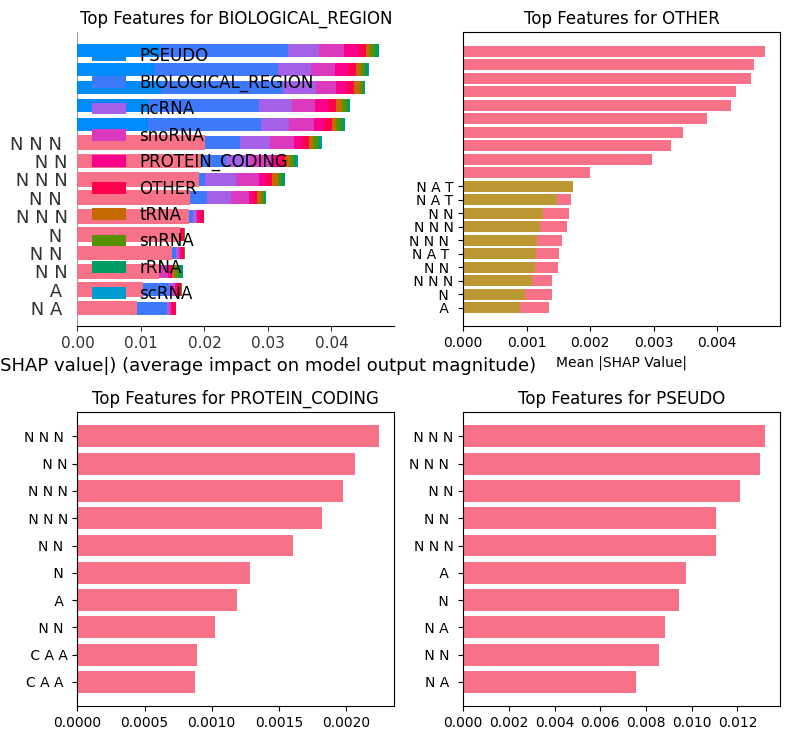


2. LIME Analysis...
Explaining prediction for sequence 0...



3. Attention Visualization...



4. Integrated Gradients Analysis...
Analyzing sequence using LayerIntegratedGradients...



5. Ensemble Analysis...
Analyzing ensemble model contributions...
N-gram Accuracy: 0.820
LSTM Accuracy: 0.955
Ensemble Accuracy: 0.970
Model Agreement: 0.820


An unexpected error occurred during XAI analysis: name 'disagreement_mask' is not defined


In [45]:
# Call the main analysis function
# Assuming your model files are in the same directory as this script.
results = run_comprehensive_xai_analysis(
    test_data_path='/kaggle/input/dna-sequence-prediction/test.csv',
    model_directory='.'
)